In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.preprocessing import StandardScaler

from scipy.stats import uniform, loguniform

import pickle

In [2]:
precomputed = ['Ecosystem Vitality', 'Environmental Health', 'Air Quality', 'Sanitation & Drinking Water']

In [3]:
df = pd.read_csv('../data/dataframes/epi_cleaned.csv')

In [4]:
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
epi_2020 = df[df['year'] == 2020]

In [6]:
epi_2020.reset_index(inplace=True)

In [7]:
def country_list(num_countries, top=True):
    if top:
        index_list_high = epi_2020['Environmental Performance Index'].sort_values(ascending=False).head(num_countries).index
        top_country_list = []
        for index in index_list_high:
            top_country_list.append(epi_2020.loc[index, 'country_name'])
        return top_country_list
    else:
        index_list_low = epi_2020['Environmental Performance Index'].sort_values(ascending=False).tail(num_countries).index
        bot_country_list = []
        for index in index_list_low:
            bot_country_list.append(epi_2020.loc[index, 'country_name'])
        return bot_country_list

# line reg:

In [8]:
precomputed = ['Ecosystem Vitality', 'Environmental Health', 'Air Quality', 'Sanitation & Drinking Water',
              'Biodiversity & Habitat']
drop_list = precomputed
drop_list.append('Environmental Performance Index')
drop_list.append('country_name')

In [9]:
def quick_regressions(size, dataframe, column, target, top=True):
    if top:
        func_list = country_list(size, top=True)
        func_df = dataframe[dataframe[column].isin(func_list)]
    if not top:
        func_list = country_list(size, top=False)
        func_df = dataframe[dataframe[column].isin(func_list)]
        
    X = func_df.drop(columns=drop_list)
    y = func_df[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
    
    sc = StandardScaler()
    Xs_train = sc.fit_transform(X_train)
    Xs_test = sc.transform(X_test)
    
    #line reg
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    print(f'basic line reg scores: train:{lr.score(X_train,y_train)}')
    print(f'basic line reg scores: test:{lr.score(X_test,y_test)}')
    
    coefs = pd.DataFrame(zip(lr.coef_, X.columns), columns=[f'{size} lr_coef', f'{size} feature'])
    coefs[f'{size} lr_coef']= coefs[f'{size} lr_coef'].map(lambda x: abs(x))
    coefs.sort_values(f'{size} lr_coef',ascending=False, inplace=True)
    coefs.reset_index(inplace=True,drop=True)

    #lasso
    lasso = Lasso(random_state = 42, selection = 'random')

    lasso_pipe_params = {
        'alpha': loguniform(.001, 100),
        'tol': loguniform(.00001, .001),
        'max_iter': uniform(100, 10000)
    }

    lasso_rs = RandomizedSearchCV(lasso, param_distributions = lasso_pipe_params, 
                             cv = 5,n_iter=1000,verbose=1, n_jobs = -2, random_state = 42)
    lasso_rs.fit(Xs_train, y_train)
    print(f'lasso line reg scores: train:{lasso_rs.score(Xs_train,y_train)}')
    print(f'lasso line reg scores: test:{lasso_rs.score(Xs_test,y_test)}')

    coefs_lasso = pd.DataFrame(zip(lasso_rs.best_estimator_.coef_, X.columns), columns=[f'{size} lasso_coef', f'{size} lasso feature'])
    coefs_lasso[f'{size} lasso_coef']= coefs_lasso[f'{size} lasso_coef'].map(lambda x: abs(x))
    coefs_lasso.sort_values(f'{size} lasso_coef',ascending=False, inplace=True)
    coefs_lasso.reset_index(inplace=True,drop=True)

    
    #ridge
    ridge = Ridge(random_state = 42)

    ridge_pipe_params = {
        'alpha': loguniform(.001, 100),
        'tol': loguniform(.00001, .001),
        'max_iter': uniform(100, 10000)
    }

    ridge_rs = RandomizedSearchCV(ridge, param_distributions = ridge_pipe_params,
                                  cv = 5, n_jobs = -2,n_iter=1000,verbose=1, random_state = 42)
    ridge_rs.fit(Xs_train, y_train)
    print(f'ridge line reg scores: train:{ridge_rs.score(Xs_train,y_train)}')
    print(f'ridge line reg scores: test:{ridge_rs.score(Xs_test,y_test)}')
    
    
    coefs_ridge = pd.DataFrame(zip(ridge_rs.best_estimator_.coef_, X.columns), columns=[f'{size} ridge_coef', f'{size} ridge feature'])
    coefs_ridge[f'{size} ridge_coef']= coefs_ridge[f'{size} ridge_coef'].map(lambda x: abs(x))
    coefs_ridge.sort_values((f'{size} ridge_coef'),ascending=False, inplace=True)
    coefs_ridge.reset_index(inplace=True, drop=True)
    
    
    return coefs, coefs_lasso, coefs_ridge

LR top countries

In [195]:
value_list = [25,50,75,89]
top_lrdf_list = []
for value in value_list:
    a, b, c = lr_coef_value = quick_regressions(value, df, 'country_name', 'Environmental Performance Index')
    top_lrdf_list.append(a)
    top_lrdf_list.append(b)
    top_lrdf_list.append(c)

basic line reg scores: train:0.6486158146747809
basic line reg scores: test:0.6760579025749429
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1177.3047294499645, tolerance: 0.5095691160113379
  model = cd_fast.enet_coordinate_descent(


lasso line reg scores: train:0.6484350800484957
lasso line reg scores: test:0.6795102236232411
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.6483660583935191
ridge line reg scores: test:0.6805997270174287
basic line reg scores: train:0.8440435852408574
basic line reg scores: test:0.8536785905608141
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8434054455949893
lasso line reg scores: test:0.8523438774999561
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8437841256992428
ridge line reg scores: test:0.8538292516969871
basic line reg scores: train:0.8821372076389266
basic line reg scores: test:0.8918323186859808
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8820027090667375
lasso line reg scores: test:0.8911694912967417
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line

In [198]:
top_countries_df_lr= pd.DataFrame()
for i in top_lrdf_list:
    top_countries_df_lr[i.columns[0]] = i.iloc[:,0]
    top_countries_df_lr[i.columns[1]] = i.iloc[:,1]

In [201]:
top_countries_df_lr.head(2)

25 lr_coef             25 feature  25 lasso_coef  \
0    0.718921  Household Air Quality       2.648602   
1    0.192295            Agriculture       2.318836   

                                  25 lasso feature  25 ridge_coef  \
0                                      Agriculture       2.617842   
1  Terrestrial biome protection (national weights)       2.292822   

                                  25 ridge feature  50 lr_coef  \
0                                      Agriculture    0.149975   
1  Terrestrial biome protection (national weights)    0.121477   

              50 feature  50 lasso_coef       50 lasso feature  ...  \
0  Unsafe drinking water       3.191184        Water Resources  ...   
1            Agriculture       2.446094  Unsafe drinking water  ...   

   75 lasso_coef                               75 lasso feature  \
0       3.729761                                Water Resources   
1       2.864605  Terrestrial biome protection (global weights)   

   75 ridge_coef      75 ridge feature  89 lr_coef  \
0        3.03826  Wastewater Treatment    0.124228   
1        3.03826       Water Resources    0.115575   

                                      89 feature  89 lasso_coef  \
0                                 Health Impacts       3.567513   
1  Terrestrial biome protection (global weights)       3.469186   

                                89 lasso feature  89 ridge_coef  \
0                                Water Resources       3.368876   
1  Terrestrial biome protection (global weights)       3.077623   

                                89 ridge feature  
0  Terrestrial biome protection (global weights)  
1                           Wastewater Treatment  

[2 rows x 24 columns]

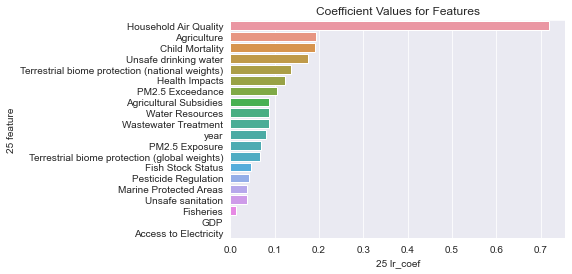

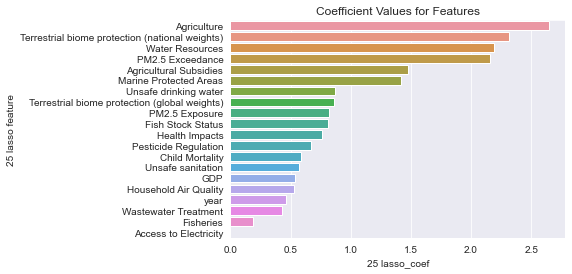

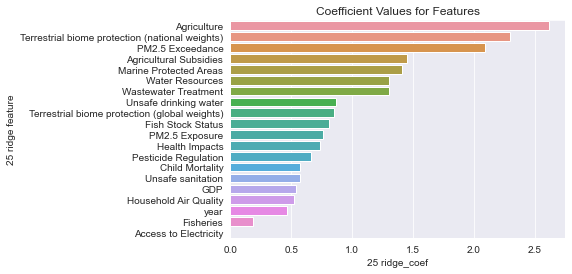

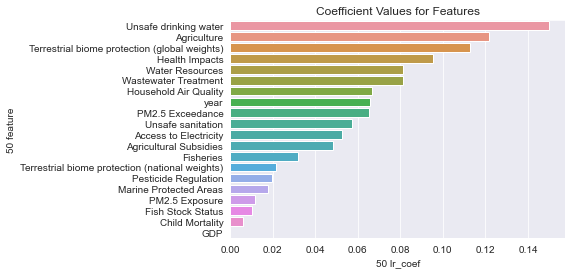

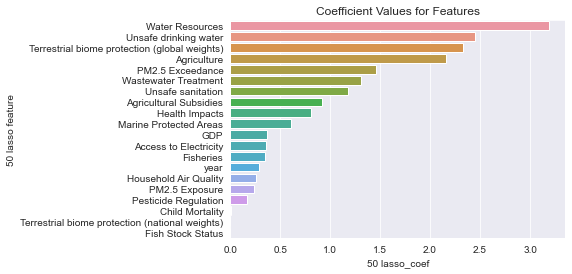

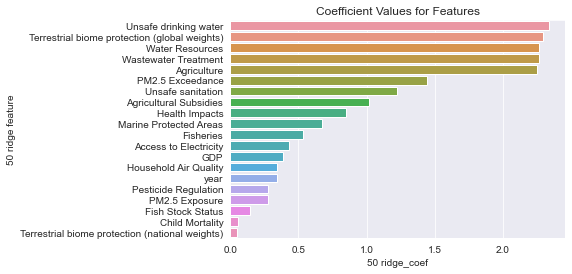

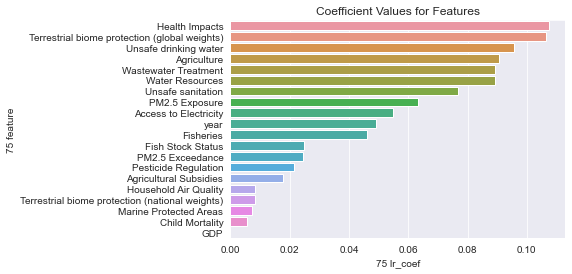

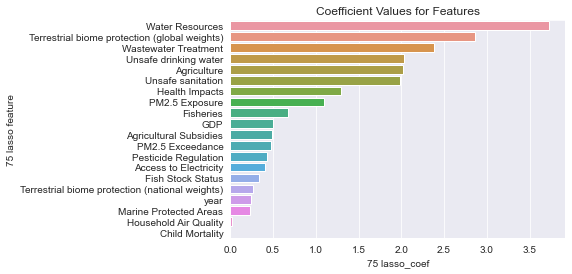

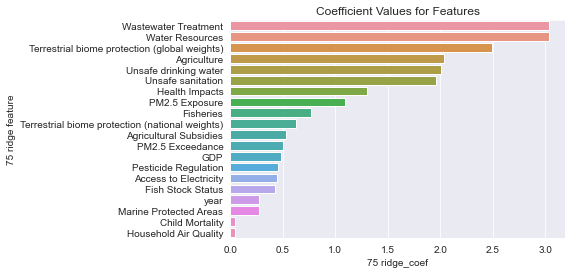

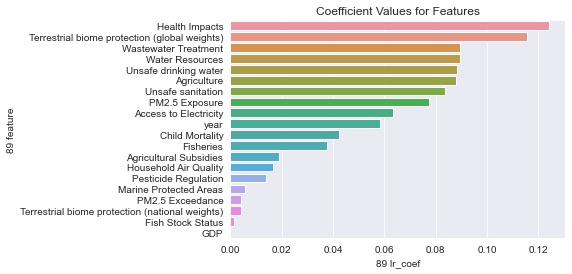

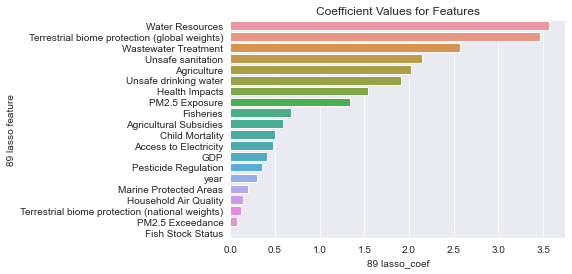

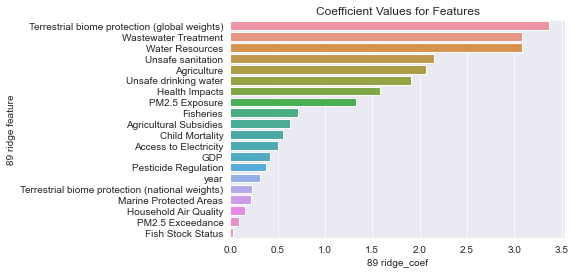

In [235]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=top_countries_df_lr,
    y = top_countries_df_lr.iloc[:,y_counter],
    x = top_countries_df_lr.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2

In [253]:
def create_catplot_df(value_list, df):
    output_df = pd.DataFrame()
    for value in value_list:
        temp_df = df[[f'{value} feature', f'{value} lr_coef']].copy()
        temp_df.rename(columns={f'{value} feature':'feature', f'{value} lr_coef': 'coef'}, inplace=True) 
        temp_df['label'] = f'{value} lr_coef'
        output_df = pd.concat([output_df, temp_df], axis=0, ignore_index=True)
    return output_df

In [247]:
catplot_df_lr_top=create_catplot_df(value_list,top_countries_df_lr)

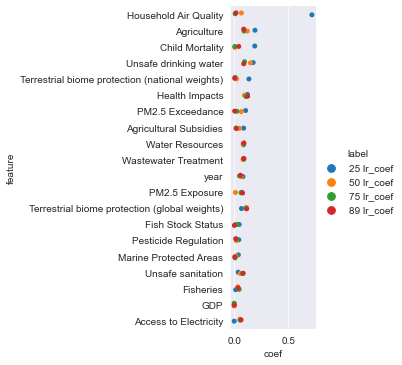

In [248]:
sns.catplot(data=catplot_df_lr_top, x='coef', y='feature', hue='label', orient='h')

bot

In [230]:
value_list = [25,50,75,89]
bot_lrdf_list = []
for value in value_list:
    a, b, c = lr_coef_value = quick_regressions(value, df, 'country_name', 'Environmental Performance Index',top=False)    
    bot_lrdf_list.append(a)
    bot_lrdf_list.append(b)
    bot_lrdf_list.append(c)

basic line reg scores: train:0.8606041008070284
basic line reg scores: test:0.8595296857024323
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8594997721550421
lasso line reg scores: test:0.8653023089513517
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8595035542271364
ridge line reg scores: test:0.8657230883890634
basic line reg scores: train:0.819469212085264
basic line reg scores: test:0.7872904962378657
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8192660944551404
lasso line reg scores: test:0.7881463567302338
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8188289163517588
ridge line reg scores: test:0.7880136478893423
basic line reg scores: train:0.8477949240990064
basic line reg scores: test:0.8484801596228363
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line 

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 611.8621390006228, tolerance: 30.28070288485822
  model = cd_fast.enet_coordinate_descent(


lasso line reg scores: train:0.849566466279538
lasso line reg scores: test:0.8463037432436911
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8494714749484705
ridge line reg scores: test:0.8468818795493843


In [236]:
bot_countries_df_lr= pd.DataFrame()
for i in bot_lrdf_list:
    bot_countries_df_lr[i.columns[0]] = i.iloc[:,0]
    bot_countries_df_lr[i.columns[1]] = i.iloc[:,1]

In [237]:
bot_countries_df_lr.head(2)

25 lr_coef         25 feature  25 lasso_coef  \
0    0.305132               year       3.719389   
1    0.196332  Unsafe sanitation       2.626167   

                                25 lasso feature  25 ridge_coef  \
0  Terrestrial biome protection (global weights)       3.596678   
1                              Unsafe sanitation       2.562450   

                                25 ridge feature  50 lr_coef       50 feature  \
0  Terrestrial biome protection (global weights)    0.255677  Water Resources   
1                              Unsafe sanitation    0.222211             year   

   50 lasso_coef                                 50 lasso feature  ...  \
0       2.732334                                Unsafe sanitation  ...   
1       2.428468  Terrestrial biome protection (national weights)  ...   

   75 lasso_coef                                 75 lasso feature  \
0       2.732868  Terrestrial biome protection (national weights)   
1       2.725644                                   Health Impacts   

   75 ridge_coef                                 75 ridge feature  89 lr_coef  \
0       2.720555  Terrestrial biome protection (national weights)    0.181211   
1       2.474907                                   Health Impacts    0.179856   

        89 feature  89 lasso_coef  \
0  Water Resources       2.714596   
1             year       2.597590   

                                89 lasso feature  89 ridge_coef  \
0                                Water Resources       2.523065   
1  Terrestrial biome protection (global weights)       2.474207   

                                89 ridge feature  
0  Terrestrial biome protection (global weights)  
1                              Unsafe sanitation  

[2 rows x 24 columns]

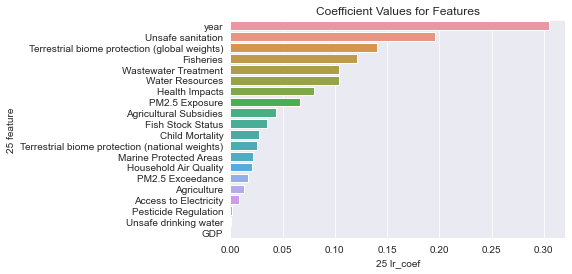

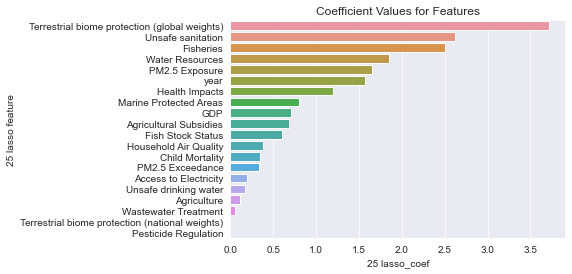

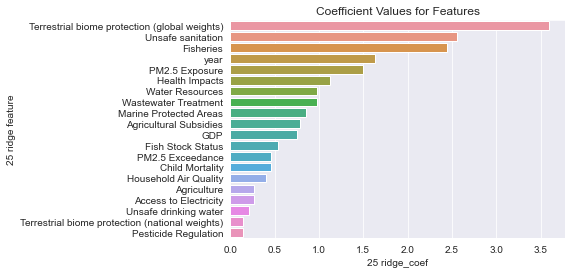

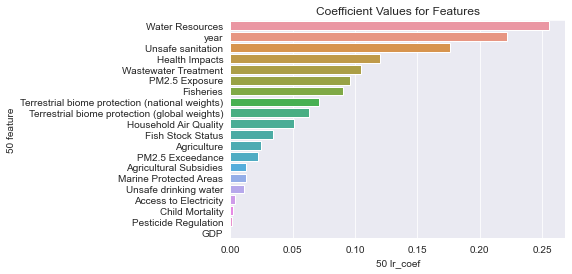

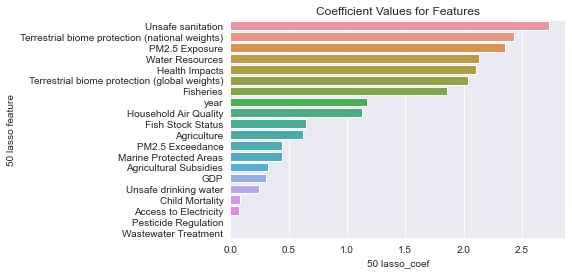

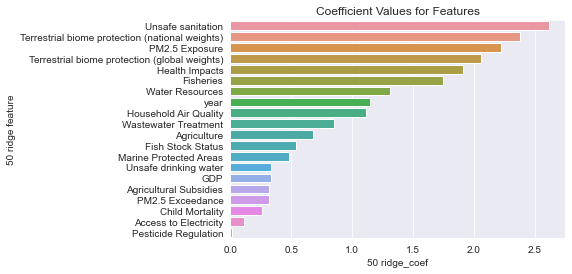

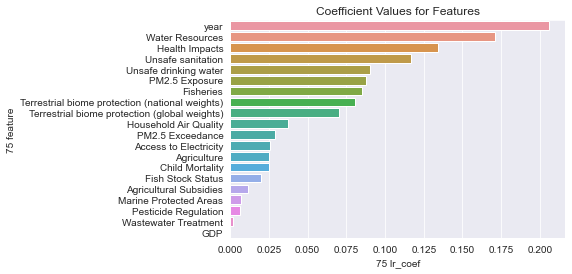

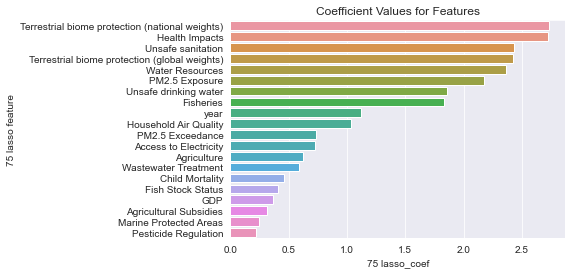

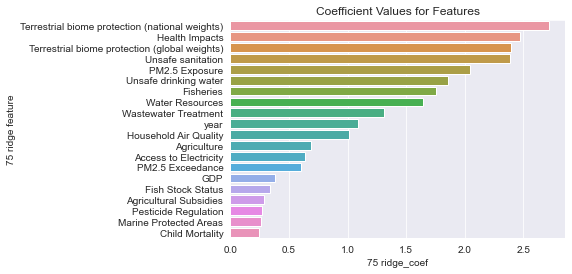

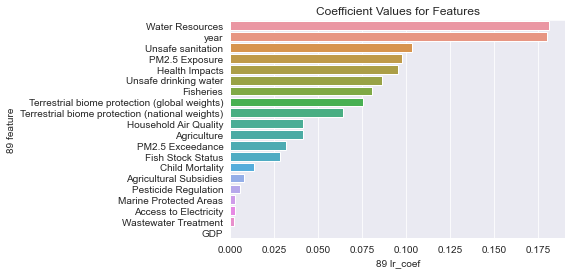

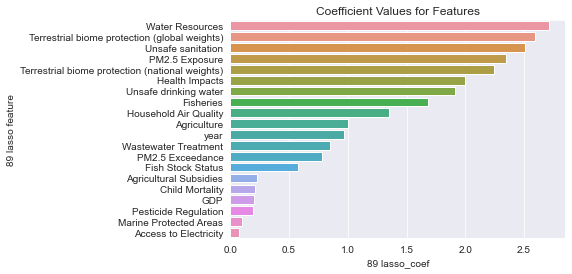

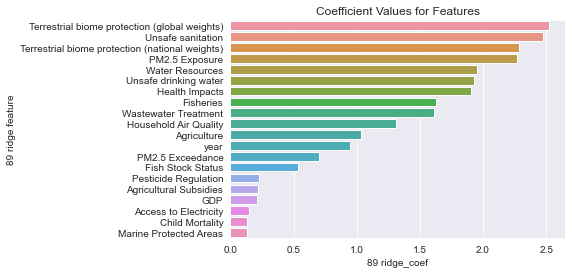

In [238]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=bot_countries_df_lr,
    y = bot_countries_df_lr.iloc[:,y_counter],
    x = bot_countries_df_lr.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2

In [255]:
catplot_df_lr_bot = create_catplot_df(value_list,bot_countries_df_lr)

In [256]:
catplot_df_lr_bot

feature          coef       label
0                                            year  3.051320e-01  25 lr_coef
1                               Unsafe sanitation  1.963316e-01  25 lr_coef
2   Terrestrial biome protection (global weights)  1.402971e-01  25 lr_coef
3                                       Fisheries  1.216658e-01  25 lr_coef
4                            Wastewater Treatment  1.036874e-01  25 lr_coef
..                                            ...           ...         ...
75                           Pesticide Regulation  5.401625e-03  89 lr_coef
76                         Marine Protected Areas  2.785442e-03  89 lr_coef
77                          Access to Electricity  2.730556e-03  89 lr_coef
78                           Wastewater Treatment  2.171838e-03  89 lr_coef
79                                            GDP  1.487838e-13  89 lr_coef

[80 rows x 3 columns]

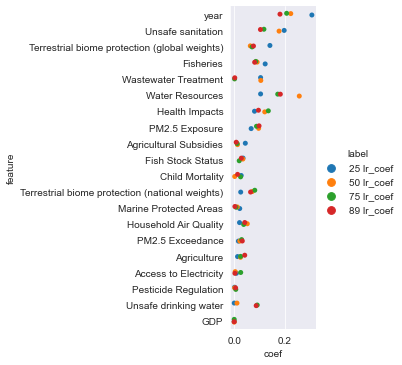

In [257]:
sns.catplot(data=catplot_df_lr_bot, x='coef', y='feature', hue='label', orient='h')

trash below

In [10]:
lr_coefs25_top,lasso_coefs25_top,ridge_coefs25_top = quick_regressions(25,df,'country_name','Environmental Performance Index')

basic line reg scores: train:0.6486158146747809
basic line reg scores: test:0.6760579025749429
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1177.3047294499645, tolerance: 0.5095691160113379
  model = cd_fast.enet_coordinate_descent(


lasso line reg scores: train:0.6484350800484957
lasso line reg scores: test:0.6795102236232411
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.6483660583935191
ridge line reg scores: test:0.6805997270174287


In [11]:
lr_coefs50_top,lasso_coefs50_top,ridge_coefs50_top = quick_regressions(50,df,'country_name','Environmental Performance Index')

basic line reg scores: train:0.8440435852408574
basic line reg scores: test:0.8536785905608141
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8434054455949893
lasso line reg scores: test:0.8523438774999561
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8437841256992428
ridge line reg scores: test:0.8538292516969871


In [12]:
lr_coefs75_top,lasso_coefs75_top,ridge_coefs75_top = quick_regressions(75,df,'country_name','Environmental Performance Index')

basic line reg scores: train:0.8821372076389266
basic line reg scores: test:0.8918323186859808
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8820027090667375
lasso line reg scores: test:0.8911694912967417
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.882005795219131
ridge line reg scores: test:0.8914302918166839


In [13]:
lr_coefs89_top,lasso_coefs89_top,ridge_coefs89_top = quick_regressions(89,df,'country_name','Environmental Performance Index')

basic line reg scores: train:0.8937126796999254
basic line reg scores: test:0.8975329415618667
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.893677277636768
lasso line reg scores: test:0.89785847609998
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8937060268377784
ridge line reg scores: test:0.8975795728581024


best test score: lasso: 0.89758
ridge peforms the best in all but the half and half model, will look at ridge going forward. 

LR bottom countries:

In [14]:
lr_coefs25_bot,lasso_coefs25_bot,ridge_coefs25_bot = quick_regressions(25,df,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8606041008070284
basic line reg scores: test:0.8595296857024323
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8594997721550421
lasso line reg scores: test:0.8653023089513517
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8595035542271364
ridge line reg scores: test:0.8657230883890634


In [15]:
lr_coefs50_bot,lasso_coefs50_bot,ridge_coefs50_bot = quick_regressions(50,df,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.819469212085264
basic line reg scores: test:0.7872904962378657
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8192660944551404
lasso line reg scores: test:0.7881463567302338
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8188289163517588
ridge line reg scores: test:0.7880136478893423


In [16]:
lr_coefs75_bot,lasso_coefs75_bot,ridge_coefs75_bot = quick_regressions(75,df,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8477949240990064
basic line reg scores: test:0.8484801596228363
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8477722424127593
lasso line reg scores: test:0.8485043760555604
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8475449574898535
ridge line reg scores: test:0.848473402887403


In [17]:
lr_coefs89_bot,lasso_coefs89_bot,ridge_coefs89_bot = quick_regressions(89,df,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8495943227765198
basic line reg scores: test:0.8461514163421449
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 611.8621390006228, tolerance: 30.28070288485822
  model = cd_fast.enet_coordinate_descent(


lasso line reg scores: train:0.849566466279538
lasso line reg scores: test:0.8463037432436911
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8494714749484705
ridge line reg scores: test:0.8468818795493843


also confirmed that ridge is the best performer in all categories. 

table of those values to compare side to side.

In [18]:
top_countries_df = lr_coefs25_top.copy()
bot_countries_df = lr_coefs25_bot.copy()

In [19]:
top_df_list = [lr_coefs50_top, lr_coefs75_top, lr_coefs89_top, lasso_coefs25_top,
               lasso_coefs50_top, lasso_coefs75_top, lasso_coefs89_top, ridge_coefs25_top,
              ridge_coefs50_top, ridge_coefs75_top, ridge_coefs89_top]
bot_df_list =  [lr_coefs50_bot, lr_coefs75_bot, lr_coefs89_bot, lasso_coefs25_bot,
               lasso_coefs50_bot, lasso_coefs75_bot, lasso_coefs89_bot, ridge_coefs25_bot,
              ridge_coefs50_bot, ridge_coefs75_bot, ridge_coefs89_bot]

In [20]:
for i in top_df_list:
    top_countries_df[i.columns[0]] = i.iloc[:,0]
    top_countries_df[i.columns[1]] = i.iloc[:,1]

In [21]:
for i in bot_df_list:
    bot_countries_df[i.columns[0]] = i.iloc[:,0]
    bot_countries_df[i.columns[1]] = i.iloc[:,1]

In [22]:
top_countries_df.shape

(20, 24)

In [23]:
bot_countries_df.shape

(20, 24)

In [24]:
sns.set_style('darkgrid')

top countries

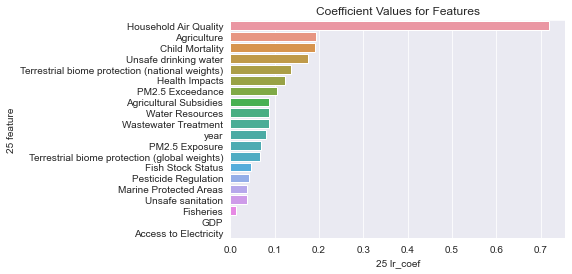

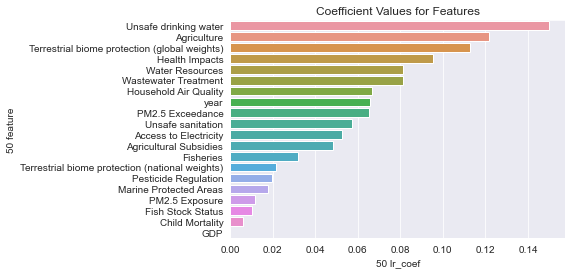

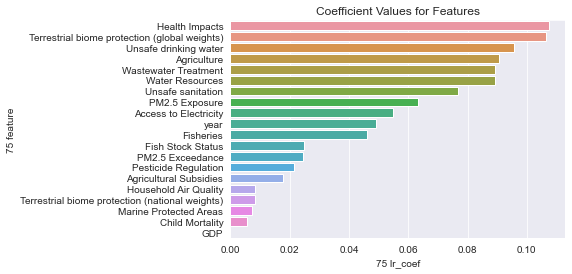

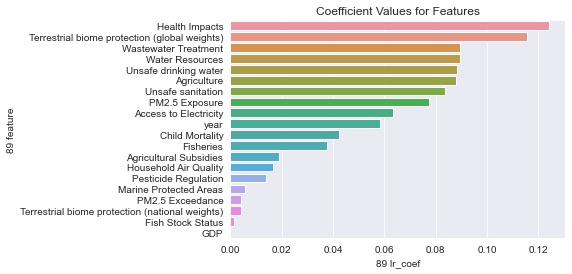

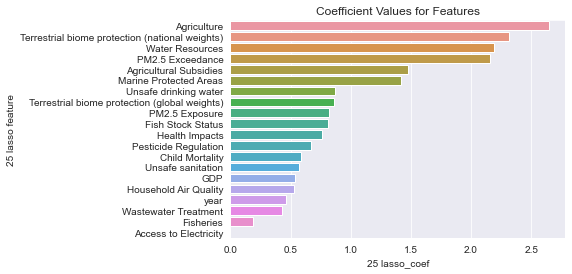

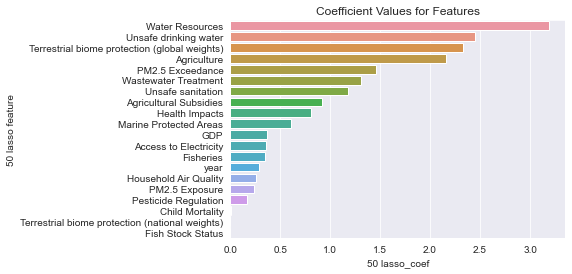

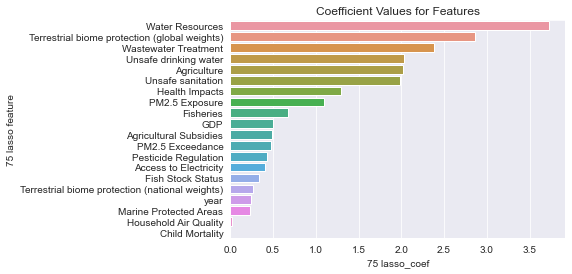

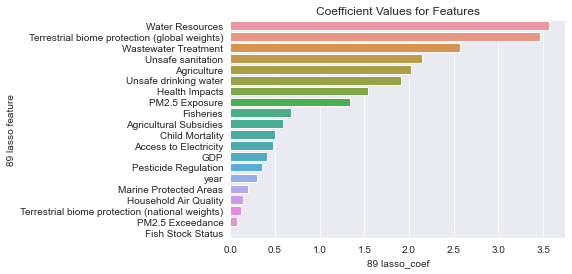

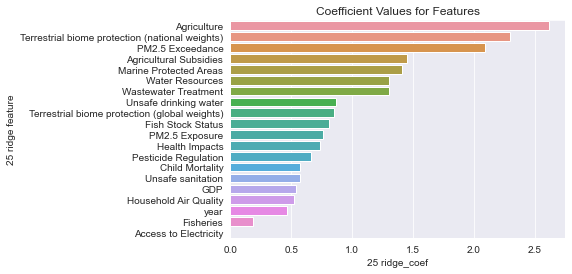

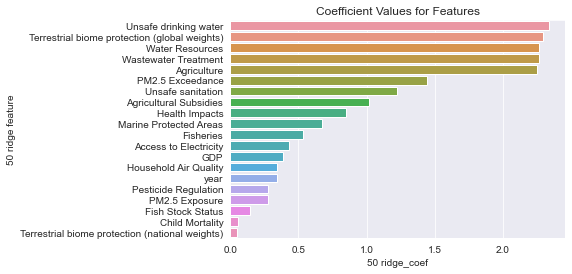

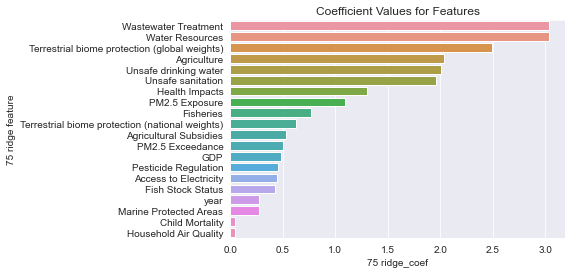

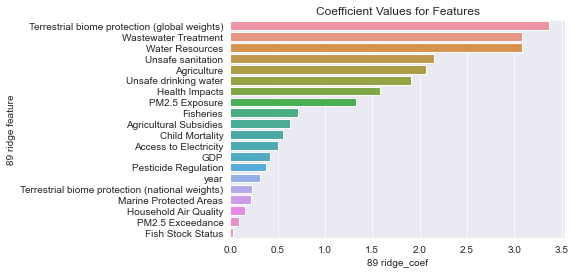

In [25]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=top_countries_df,
    y = top_countries_df.iloc[:,y_counter],
    x = top_countries_df.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2


Bottom countries:

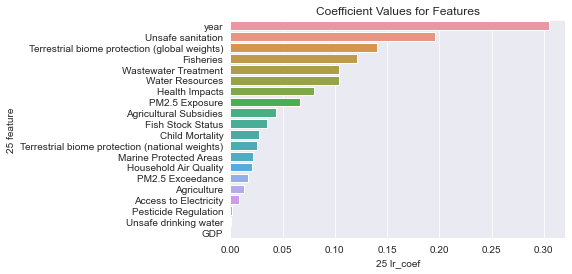

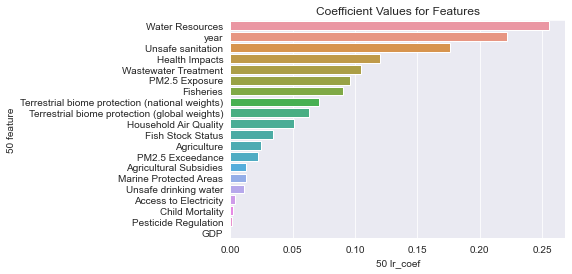

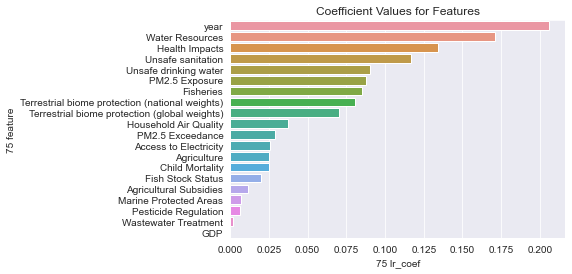

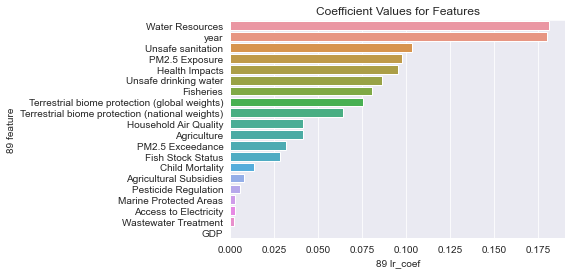

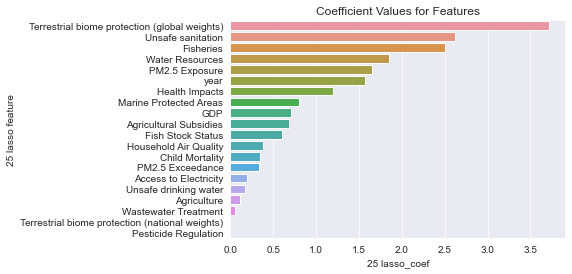

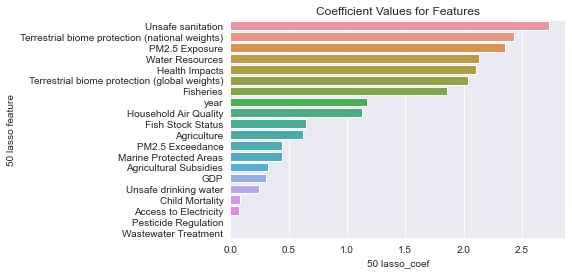

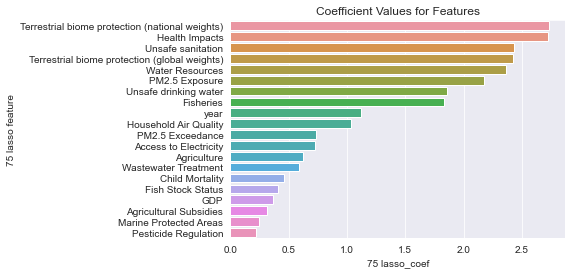

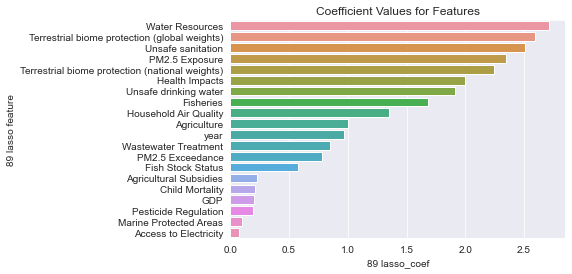

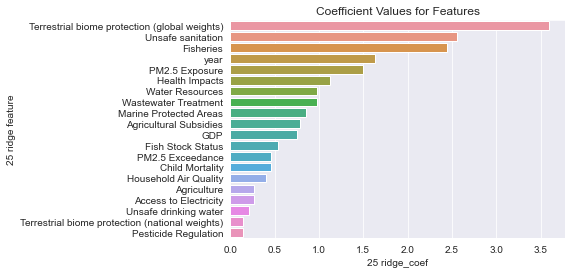

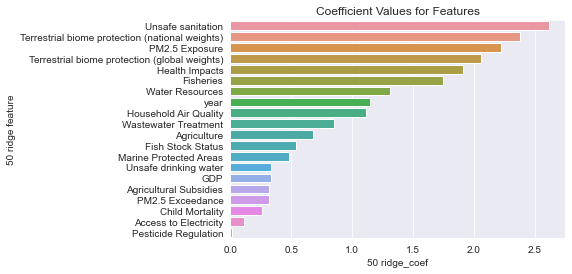

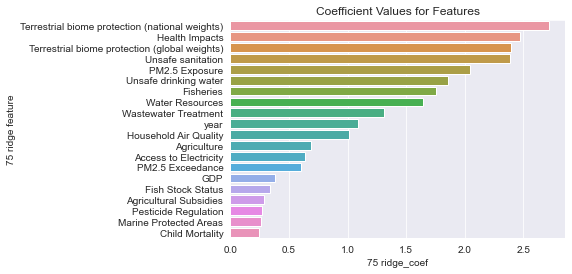

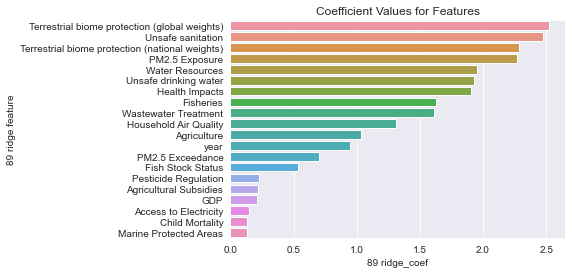

In [26]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=top_countries_df,
    y = bot_countries_df.iloc[:,y_counter],
    x = bot_countries_df.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2


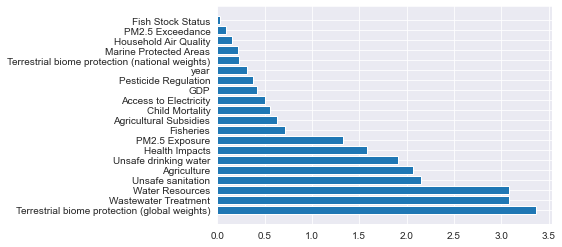

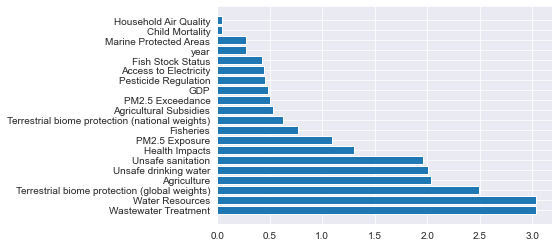

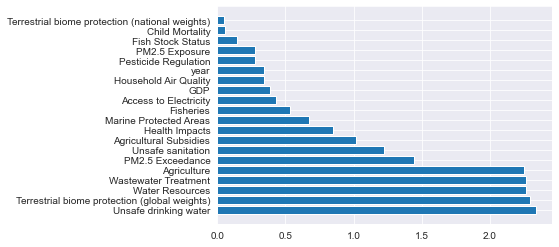

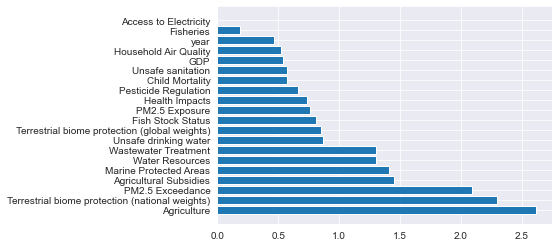

In [27]:

plt.barh( top_countries_df['89 ridge feature'], top_countries_df['89 ridge_coef'])
plt.show()
plt.barh(top_countries_df['75 ridge feature'], top_countries_df['75 ridge_coef'])
plt.show()
plt.barh(top_countries_df['50 ridge feature'], top_countries_df['50 ridge_coef'])
plt.show()
plt.barh(top_countries_df['25 ridge feature'], top_countries_df['25 ridge_coef'])
plt.show()

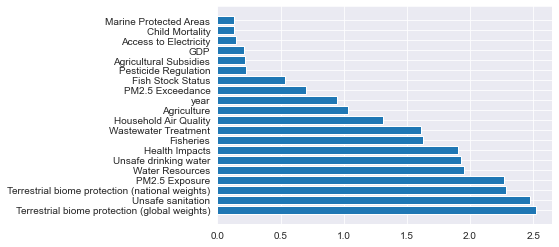

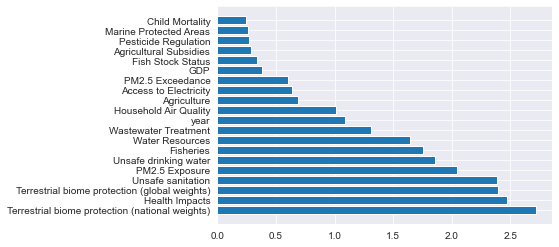

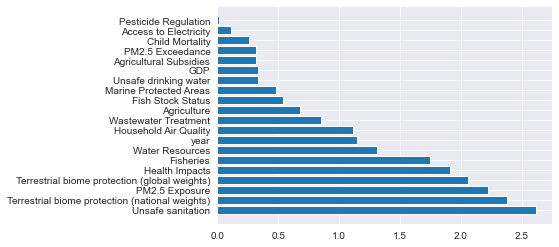

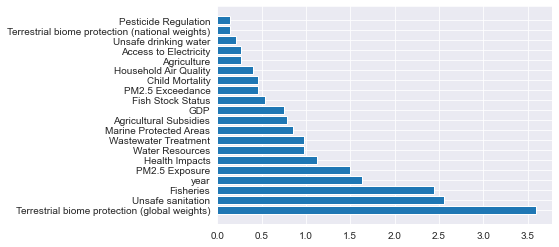

In [28]:
plt.barh( bot_countries_df['89 ridge feature'], bot_countries_df['89 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['75 ridge feature'], bot_countries_df['75 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['50 ridge feature'], bot_countries_df['50 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['25 ridge feature'], bot_countries_df['25 ridge_coef'])
plt.show()

pre 2015

In [29]:
df_pre_2015 = df[df['year'] <=2015].copy()

In [30]:
df_pre_2015

year country_name  Sanitation & Drinking Water  Unsafe drinking water  \
0     2002       Mexico                       35.440                  41.86   
1     2003       Mexico                       36.470                  43.07   
2     2004       Mexico                       37.530                  44.34   
3     2005       Mexico                       38.630                  45.65   
4     2006       Mexico                       39.760                  47.02   
...    ...          ...                          ...                    ...   
3352  2011      Senegal                       16.490                  20.43   
3353  2012      Senegal                       16.490                  20.43   
3354  2013      Senegal                       16.490                  20.43   
3355  2014      Senegal                       16.490                  20.43   
3356  2015      Senegal                       36.755                  38.87   

      PM2.5 Exposure  Air Quality  Marine Protected Areas  \
0              91.43        81.34                  80.190   
1              90.67        80.98                  80.190   
2              92.13        82.32                  80.190   
3              91.92        82.26                  81.340   
4              94.25        84.01                  81.340   
...              ...          ...                     ...   
3352          100.00        83.00                  77.210   
3353          100.00        83.00                  77.210   
3354          100.00        83.00                  77.210   
3355          100.00        83.00                  77.210   
3356          100.00        79.39                  80.065   

      Biodiversity & Habitat  Ecosystem Vitality  Wastewater Treatment  ...  \
0                      56.46               43.26                37.450  ...   
1                      58.20               43.85                37.450  ...   
2                      59.97               45.85                37.450  ...   
3                      59.87               44.00                37.450  ...   
4                      60.26               44.02                37.450  ...   
...                      ...                 ...                   ...  ...   
3352                   85.36               38.16                 2.060  ...   
3353                   85.36               38.16                 2.060  ...   
3354                   85.36               38.16                 2.060  ...   
3355                   85.36               38.16                 2.060  ...   
3356                   89.36               52.63                18.175  ...   

      Agriculture  Fisheries  PM2.5 Exceedance  Household Air Quality  \
0           46.50      26.34             69.78                  82.80   
1           60.54      20.82             69.06                  83.20   
2           90.00      21.67             71.22                  83.60   
3           54.62      21.12             70.86                  84.00   
4           53.29      20.99             73.38                  84.40   
...           ...        ...               ...                    ...   
3352        17.45      20.78            100.00                  49.00   
3353        17.45      20.78            100.00                  49.00   
3354        17.45      20.78            100.00                  49.00   
3355        17.45      20.78            100.00                  49.00   
3356        56.24      40.68            100.00                  55.72   

      Access to Electricity  Health Impacts  Agricultural Subsidies  \
0                     98.20          70.920                   21.00   
1                     98.30          71.500                   41.07   
2                     98.40          72.040                  100.00   
3                     98.50          72.560                   29.25   
4                     98.60          73.100                   26.58   
...                     ...             ...                     ...   
3

In [31]:
lr_coefs25_top,lasso_coefs25_top,ridge_coefs25_top = quick_regressions(25,df_pre_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.7693451559765786
basic line reg scores: test:0.7407500113867362
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.7668079135526996
lasso line reg scores: test:0.7406330440834443
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.7686912151063585
ridge line reg scores: test:0.737532501595116


In [32]:
lr_coefs50_top,lasso_coefs50_top,ridge_coefs50_top = quick_regressions(50,df_pre_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.8821456823313151
basic line reg scores: test:0.8729381774451662
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131.13957354246213, tolerance: 5.831429462129723
  model = cd_fast.enet_coordinate_descent(


lasso line reg scores: train:0.8820565942608465
lasso line reg scores: test:0.872709921425973
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8821122573290069
ridge line reg scores: test:0.8727565192779208


In [33]:
lr_coefs75_top,lasso_coefs75_top,ridge_coefs75_top = quick_regressions(75,df_pre_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.909458653196017
basic line reg scores: test:0.900986954991972
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.9094564197251903
lasso line reg scores: test:0.9010269787427871
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.9093466348086243
ridge line reg scores: test:0.9012032836244817


In [34]:
lr_coefs89_top,lasso_coefs89_top,ridge_coefs89_top = quick_regressions(89,df_pre_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.917158042946844
basic line reg scores: test:0.9117623517672258
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.9167014049294054
lasso line reg scores: test:0.9119107047894559
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.9170696718969915
ridge line reg scores: test:0.9117056225772134


bot

In [35]:
lr_coefs25_bot,lasso_coefs25_bot,ridge_coefs25_bot = quick_regressions(25,df_pre_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.9380771727055458
basic line reg scores: test:0.9405922353120187
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.9379188372279141
lasso line reg scores: test:0.940949195931019
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.9378016148051078
ridge line reg scores: test:0.9404150399080339


In [36]:
lr_coefs50_bot,lasso_coefs50_bot,ridge_coefs50_bot = quick_regressions(50,df_pre_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8431853544760379
basic line reg scores: test:0.7445145762449847
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8418969498546169
lasso line reg scores: test:0.7501747350944086
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.842679088229203
ridge line reg scores: test:0.749660869464108


In [37]:
lr_coefs75_bot,lasso_coefs75_bot,ridge_coefs75_bot = quick_regressions(75,df_pre_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8598791242466245
basic line reg scores: test:0.8614652260928852
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3240.749036949682, tolerance: 3.725469666308844
  model = cd_fast.enet_coordinate_descent(


lasso line reg scores: train:0.8597399755502436
lasso line reg scores: test:0.861126134443198
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8597370841528255
ridge line reg scores: test:0.8611488982374574


In [38]:
lr_coefs89_bot,lasso_coefs89_bot,ridge_coefs89_bot = quick_regressions(89,df_pre_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8588643513286212
basic line reg scores: test:0.8555451387601118
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8588600784971294
lasso line reg scores: test:0.8557251444383676
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8588591461044078
ridge line reg scores: test:0.8556373061981423


In [39]:
top_countries_df = lr_coefs25_top.copy()
bot_countries_df = lr_coefs25_bot.copy()

In [40]:
top_df_list = [lr_coefs50_top, lr_coefs75_top, lr_coefs89_top, lasso_coefs25_top,
               lasso_coefs50_top, lasso_coefs75_top, lasso_coefs89_top, ridge_coefs25_top,
              ridge_coefs50_top, ridge_coefs75_top, ridge_coefs89_top]
bot_df_list =  [lr_coefs50_bot, lr_coefs75_bot, lr_coefs89_bot, lasso_coefs25_bot,
               lasso_coefs50_bot, lasso_coefs75_bot, lasso_coefs89_bot, ridge_coefs25_bot,
              ridge_coefs50_bot, ridge_coefs75_bot, ridge_coefs89_bot]

In [41]:
for i in top_df_list:
    top_countries_df[i.columns[0]] = i.iloc[:,0]
    top_countries_df[i.columns[1]] = i.iloc[:,1]

In [42]:
for i in bot_df_list:
    bot_countries_df[i.columns[0]] = i.iloc[:,0]
    bot_countries_df[i.columns[1]] = i.iloc[:,1]

In [43]:
top_countries_df.shape

(20, 24)

In [44]:
bot_countries_df.shape

(20, 24)

In [45]:
sns.set_style('darkgrid')

top countries

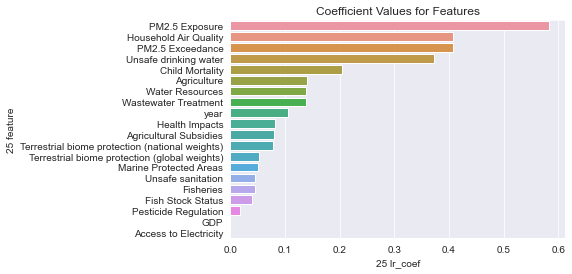

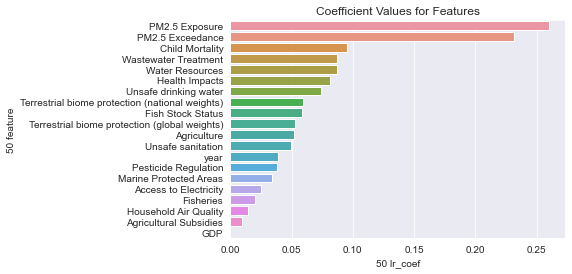

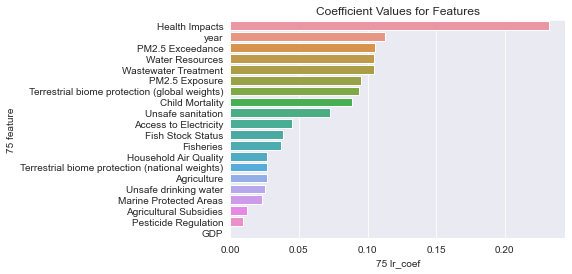

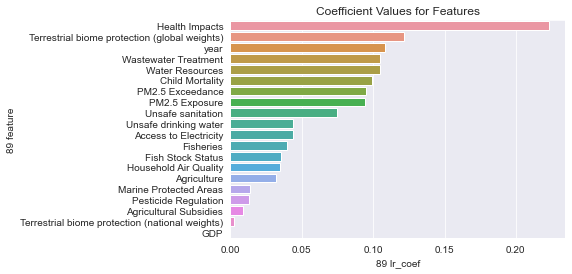

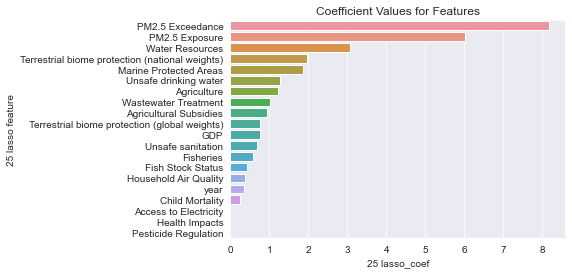

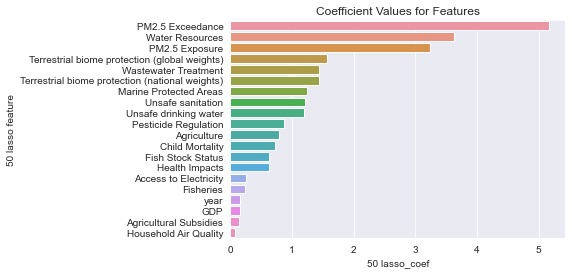

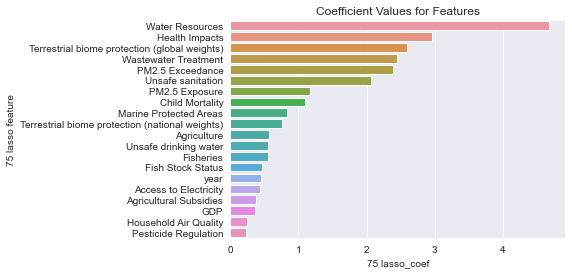

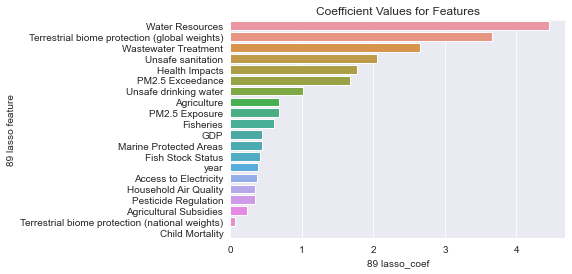

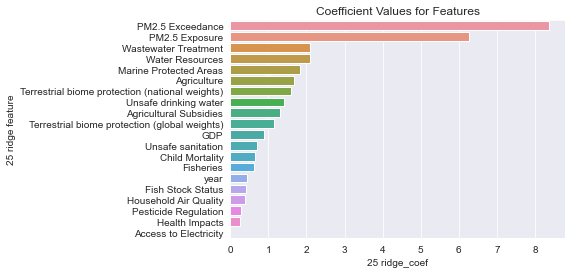

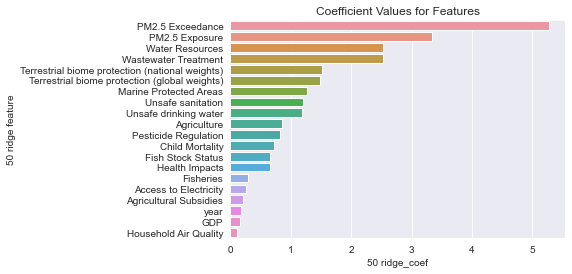

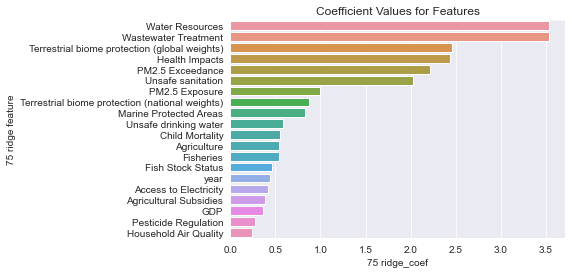

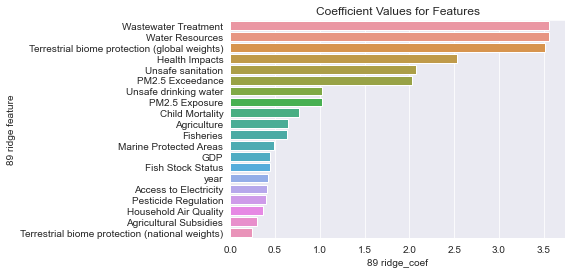

In [46]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=top_countries_df,
    y = top_countries_df.iloc[:,y_counter],
    x = top_countries_df.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2


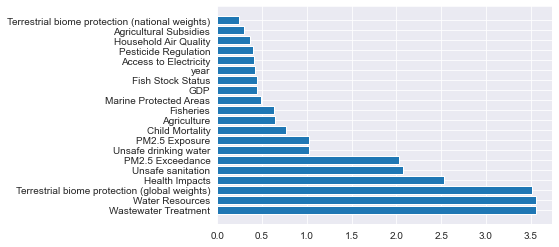

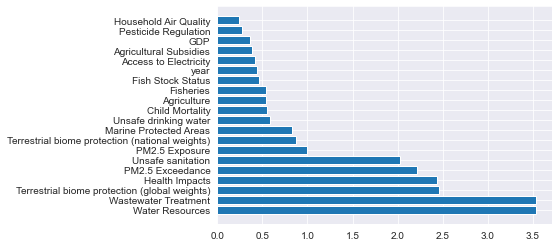

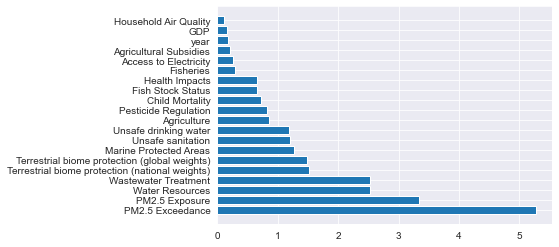

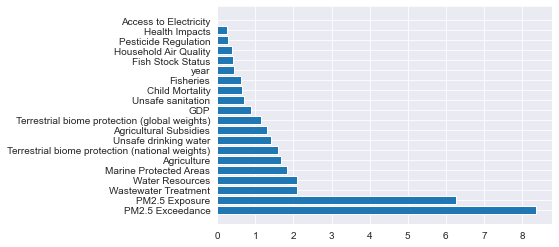

In [47]:
plt.barh( top_countries_df['89 ridge feature'], top_countries_df['89 ridge_coef'])
plt.show()
plt.barh(top_countries_df['75 ridge feature'], top_countries_df['75 ridge_coef'])
plt.show()
plt.barh(top_countries_df['50 ridge feature'], top_countries_df['50 ridge_coef'])
plt.show()
plt.barh(top_countries_df['25 ridge feature'], top_countries_df['25 ridge_coef'])
plt.show()

bot

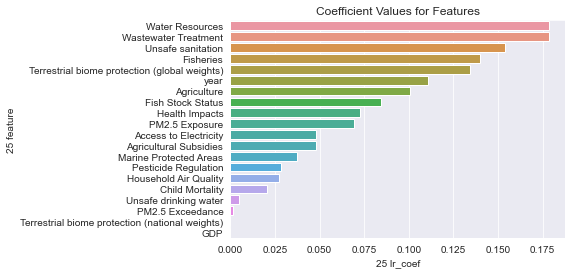

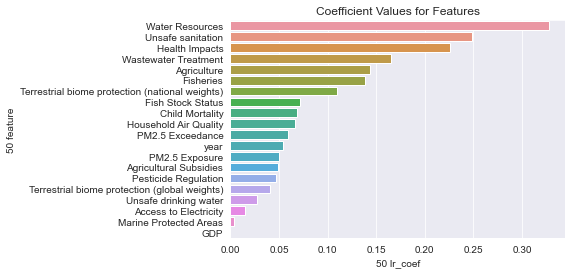

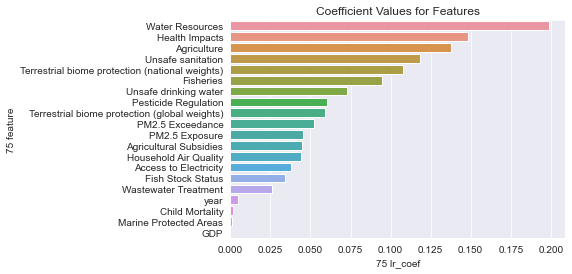

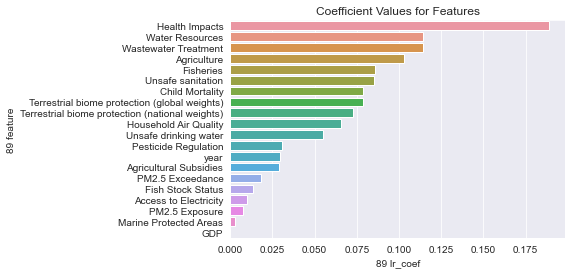

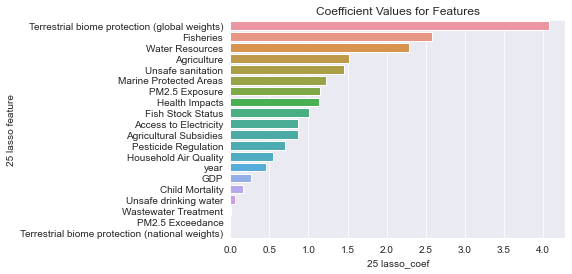

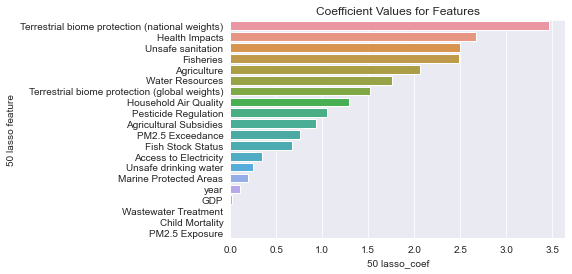

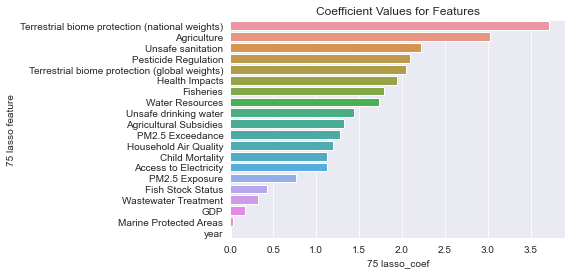

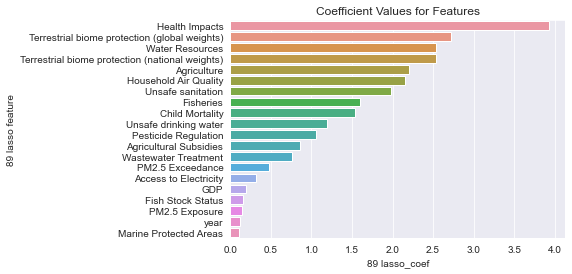

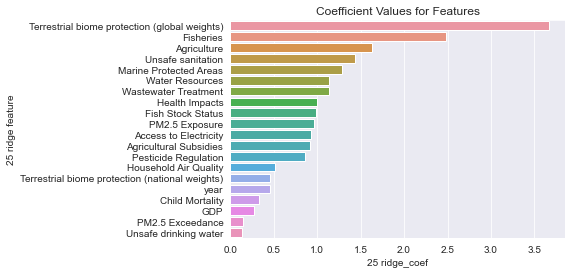

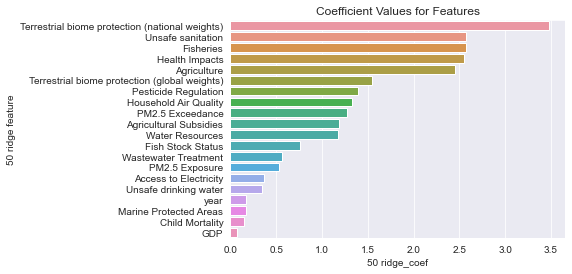

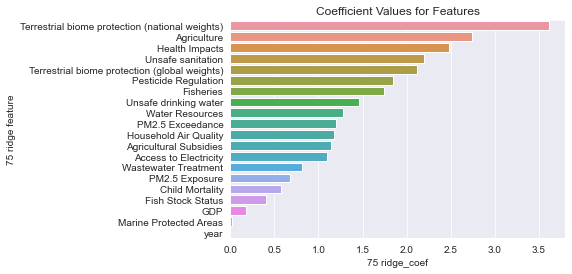

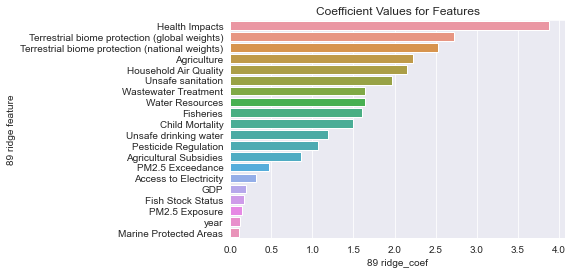

In [48]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=top_countries_df,
    y = bot_countries_df.iloc[:,y_counter],
    x = bot_countries_df.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2


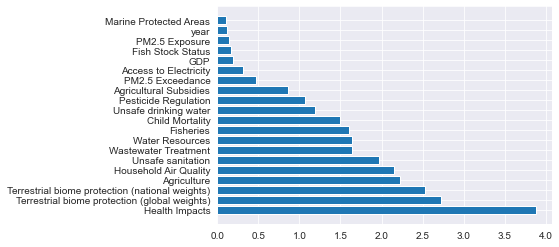

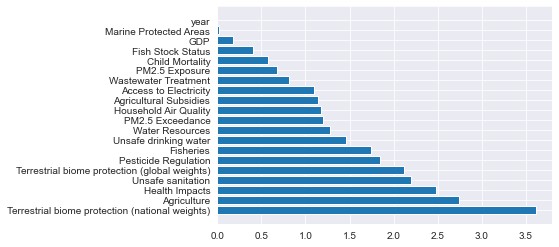

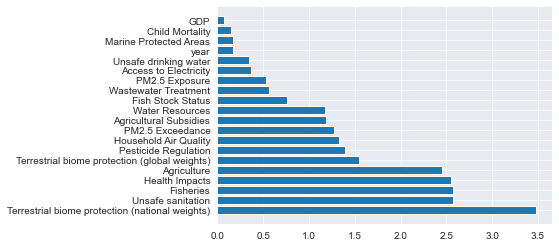

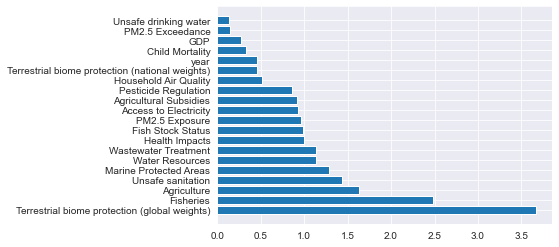

In [49]:

plt.barh( bot_countries_df['89 ridge feature'], bot_countries_df['89 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['75 ridge feature'], bot_countries_df['75 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['50 ridge feature'], bot_countries_df['50 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['25 ridge feature'], bot_countries_df['25 ridge_coef'])
plt.show()

In [50]:
df_post_2015 = df[df['year'] >2015].copy()

In [51]:
df_post_2015

year country_name  Sanitation & Drinking Water  Unsafe drinking water  \
14    2016       Mexico                       80.790                 86.630   
15    2017       Mexico                       69.185                 72.060   
16    2018       Mexico                       57.580                 57.490   
17    2019       Mexico                       55.190                 53.645   
18    2020       Mexico                       52.800                 49.800   
...    ...          ...                          ...                    ...   
3357  2016      Senegal                       57.020                 57.310   
3358  2017      Senegal                       35.345                 35.660   
3359  2018      Senegal                       13.670                 14.010   
3360  2019      Senegal                       13.385                 13.455   
3361  2020      Senegal                       13.100                 12.900   

      PM2.5 Exposure  Air Quality  Marine Protected Areas  \
14            97.450       79.550                   89.30   
15            92.570       75.725                   94.65   
16            87.690       71.900                  100.00   
17            64.945       56.350                  100.00   
18            42.200       40.800                  100.00   
...              ...          ...                     ...   
3357         100.000       75.780                   82.92   
3358         100.000       69.780                   82.66   
3359         100.000       63.780                   82.40   
3360          66.900       44.590                   44.65   
3361          33.800       25.400                    6.90   

      Biodiversity & Habitat  Ecosystem Vitality  Wastewater Treatment  ...  \
14                    78.660              69.610                80.320  ...   
15                    76.670              62.535                85.900  ...   
16                    74.680              55.460                91.480  ...   
17                    73.790              55.680                61.540  ...   
18                    72.900              55.900                31.600  ...   
...                      ...                 ...                   ...  ...   
3357                  93.360              67.100                34.290  ...   
3358                  92.515              58.965                38.490  ...   
3359                  91.670              50.830                42.690  ...   
3360                  80.185              44.215                21.595  ...   
3361                  68.700              37.600                 0.500  ...   

      Agriculture  Fisheries  PM2.5 Exceedance  Household Air Quality  \
14         79.140      55.26            70.820                  89.12   
15         56.435      50.96            78.665                  89.12   
16         33.730      46.66            86.510                  89.12   
17         36.265      29.73            86.510                  89.12   
18         38.800      12.80            86.510                  89.12   
...           ...        ...               ...                    ...   
3357       95.030      60.58           100.000                  62.44   
3358       60.760      64.65           100.000                  62.44   
3359       26.490      68.72           100.000                  62.44   
3360       32.545      40.76           100.000                  62.44   
3361       38.600      12.80           100.000                  62.44   

      Access to Electricity  Health Impacts  Agricultural Subsidies  \
14                    97.84           72.40                   30.41   
15                    97.84           72.40                   30.41   
16                    97.84           72.40                   30.41   
17                    97.84           72.40                   30.41   
18                    97.84           72.40                   30.41   
...                     ...             ...                     ...   
3

In [52]:
lr_coefs25_top,lasso_coefs25_top,ridge_coefs25_top = quick_regressions(25,df_post_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.843326955784725
basic line reg scores: test:0.8197582539025254
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.831003696254347
lasso line reg scores: test:0.8127820472139927
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8293762978066337
ridge line reg scores: test:0.803741295205778


In [53]:
lr_coefs50_top,lasso_coefs50_top,ridge_coefs50_top = quick_regressions(50,df_post_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.9236244951498196
basic line reg scores: test:0.850482694636935
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.9158000762243714
lasso line reg scores: test:0.8300890068392308
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.9231362237430502
ridge line reg scores: test:0.8496577762247133


In [54]:
lr_coefs75_top,lasso_coefs75_top,ridge_coefs75_top = quick_regressions(75,df_post_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.9161774610958529
basic line reg scores: test:0.9132620534638688
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.9158885902789794
lasso line reg scores: test:0.9141305521763837
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.9158194557076363
ridge line reg scores: test:0.9143540396885295


In [55]:
lr_coefs89_top,lasso_coefs89_top,ridge_coefs89_top = quick_regressions(89,df_post_2015,'country_name','Environmental Performance Index')

basic line reg scores: train:0.9192949005201133
basic line reg scores: test:0.9227569315721088
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.9190037366030268
lasso line reg scores: test:0.9213522090137451
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.9186747164891663
ridge line reg scores: test:0.921294318215827


bot

In [56]:
lr_coefs25_bot,lasso_coefs25_bot,ridge_coefs25_bot = quick_regressions(25,df_post_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.880251302300534
basic line reg scores: test:0.7929927242252879
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8739785163805802
lasso line reg scores: test:0.8104105128554422
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8683868947703342
ridge line reg scores: test:0.7820883562527877


In [57]:
lr_coefs50_bot,lasso_coefs50_bot,ridge_coefs50_bot = quick_regressions(50,df_post_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8725037988583356
basic line reg scores: test:0.8742340072215486
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8686714590751263
lasso line reg scores: test:0.879496654824737
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8714671967906331
ridge line reg scores: test:0.8754237631051724


In [58]:
lr_coefs75_bot,lasso_coefs75_bot,ridge_coefs75_bot = quick_regressions(75,df_post_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.8900860962377488
basic line reg scores: test:0.866801091209632
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8855893824420986
lasso line reg scores: test:0.8645001924791724
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8878843770436974
ridge line reg scores: test:0.8627349118679313


In [59]:
lr_coefs89_bot,lasso_coefs89_bot,ridge_coefs89_bot = quick_regressions(89,df_post_2015,'country_name','Environmental Performance Index', top=False)

basic line reg scores: train:0.890627838338648
basic line reg scores: test:0.8789310540385055
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8898056798315139
lasso line reg scores: test:0.8793003561106629
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8897972400158961
ridge line reg scores: test:0.879085871026367


In [60]:
top_countries_df = lr_coefs25_top.copy()
bot_countries_df = lr_coefs25_bot.copy()

In [61]:
top_df_list = [lr_coefs50_top, lr_coefs75_top, lr_coefs89_top, lasso_coefs25_top,
               lasso_coefs50_top, lasso_coefs75_top, lasso_coefs89_top, ridge_coefs25_top,
              ridge_coefs50_top, ridge_coefs75_top, ridge_coefs89_top]
bot_df_list =  [lr_coefs50_bot, lr_coefs75_bot, lr_coefs89_bot, lasso_coefs25_bot,
               lasso_coefs50_bot, lasso_coefs75_bot, lasso_coefs89_bot, ridge_coefs25_bot,
              ridge_coefs50_bot, ridge_coefs75_bot, ridge_coefs89_bot]

In [62]:
for i in top_df_list:
    top_countries_df[i.columns[0]] = i.iloc[:,0]
    top_countries_df[i.columns[1]] = i.iloc[:,1]

In [63]:
for i in bot_df_list:
    bot_countries_df[i.columns[0]] = i.iloc[:,0]
    bot_countries_df[i.columns[1]] = i.iloc[:,1]

In [64]:
top_countries_df.shape

(20, 24)

In [65]:
bot_countries_df.shape

(20, 24)

In [66]:
sns.set_style('darkgrid')

top countries

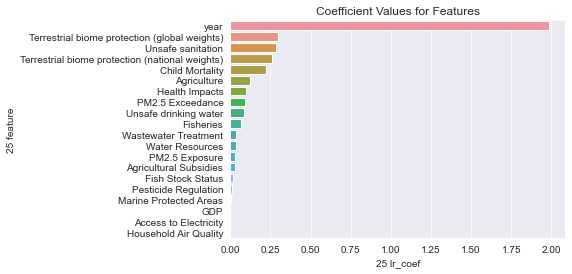

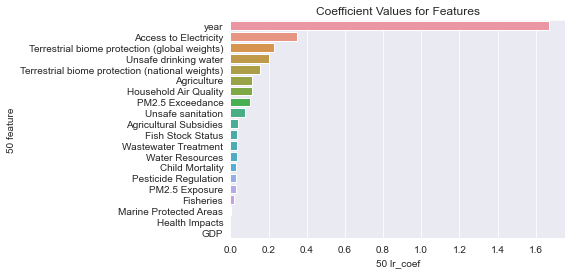

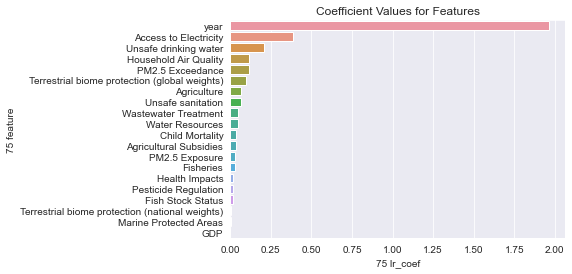

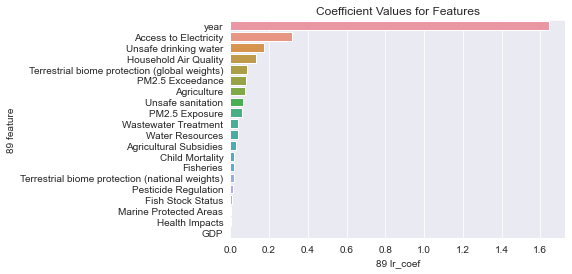

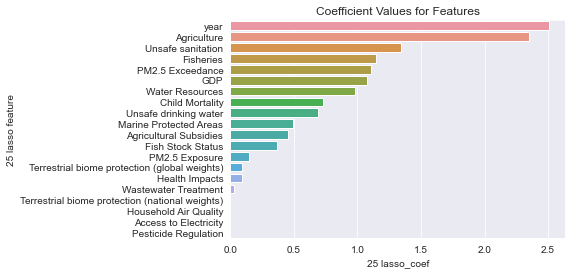

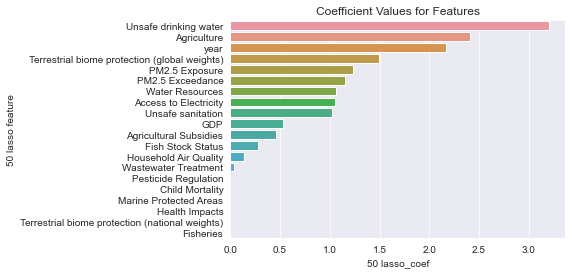

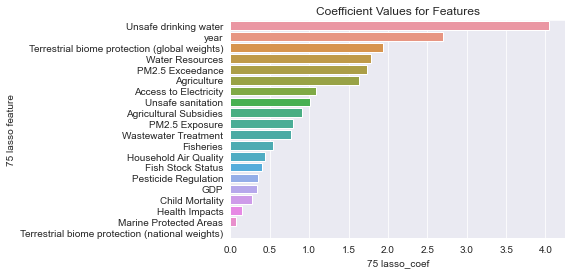

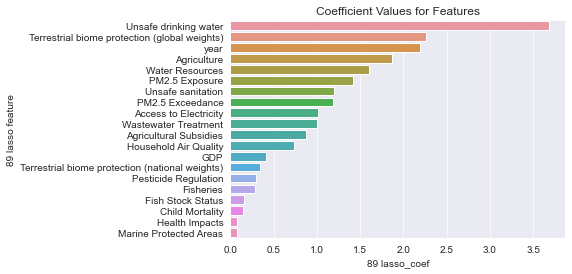

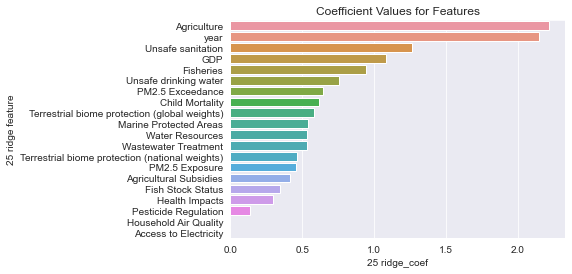

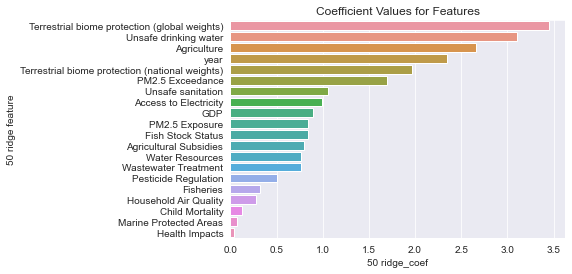

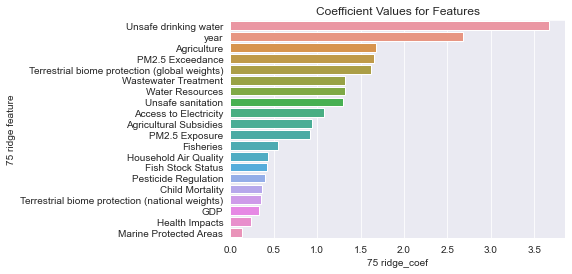

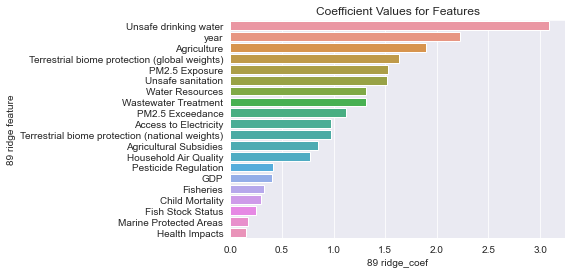

In [67]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=top_countries_df,
    y = top_countries_df.iloc[:,y_counter],
    x = top_countries_df.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2


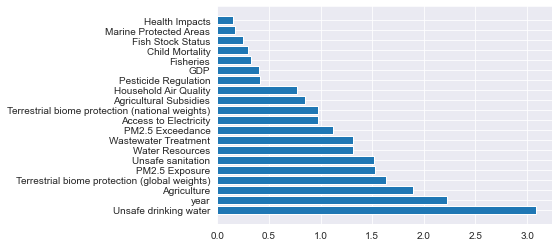

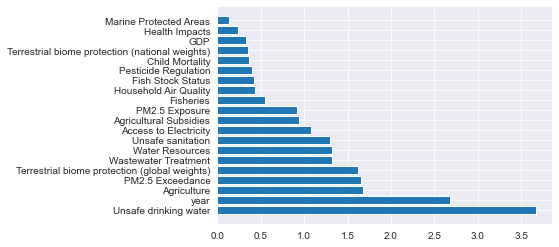

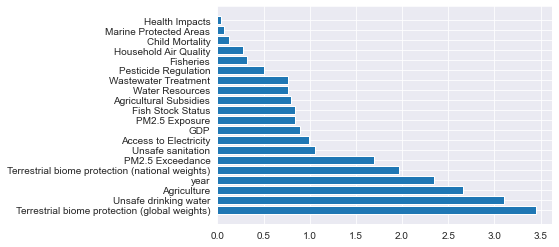

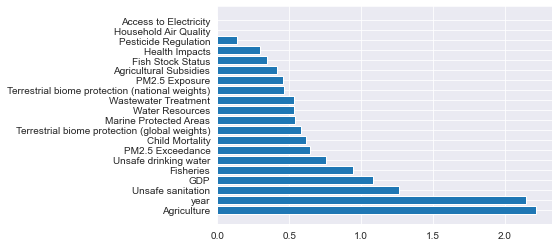

In [68]:
plt.barh( top_countries_df['89 ridge feature'], top_countries_df['89 ridge_coef'])
plt.show()
plt.barh(top_countries_df['75 ridge feature'], top_countries_df['75 ridge_coef'])
plt.show()
plt.barh(top_countries_df['50 ridge feature'], top_countries_df['50 ridge_coef'])
plt.show()
plt.barh(top_countries_df['25 ridge feature'], top_countries_df['25 ridge_coef'])
plt.show()

bot

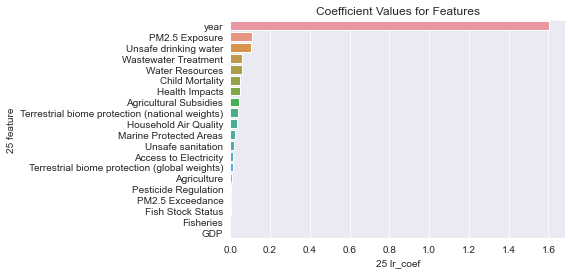

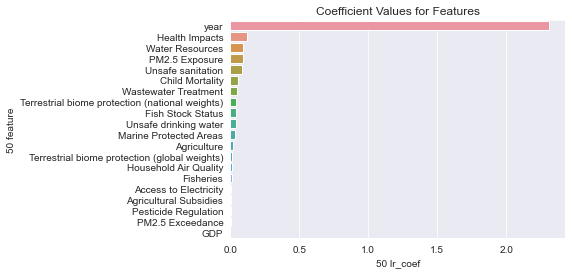

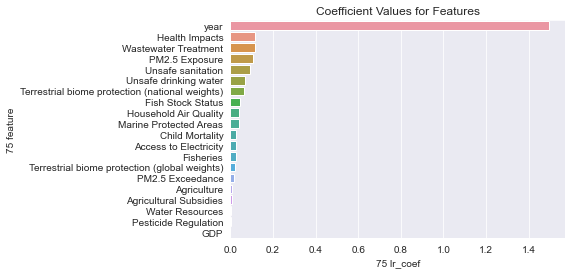

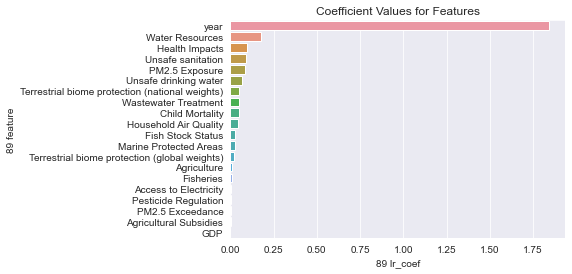

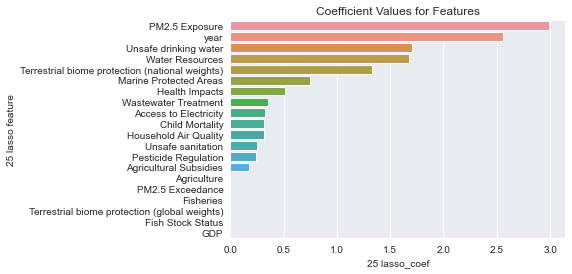

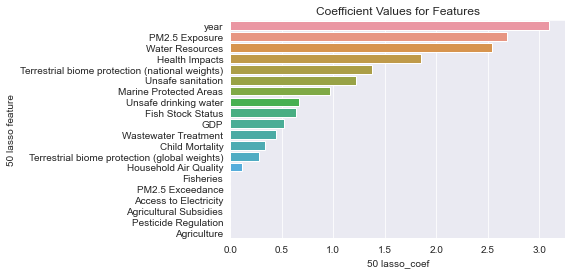

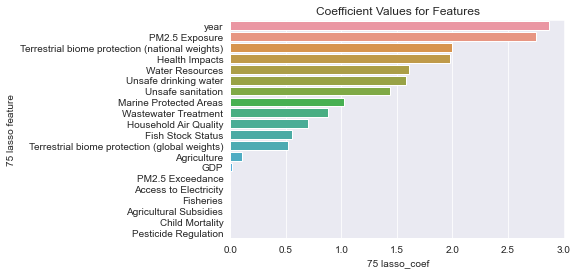

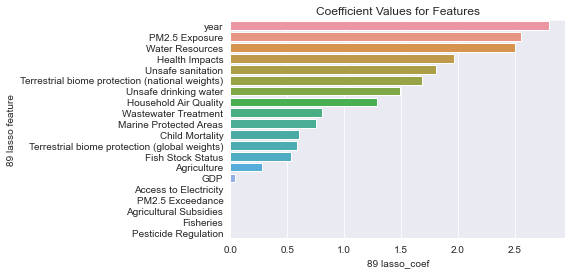

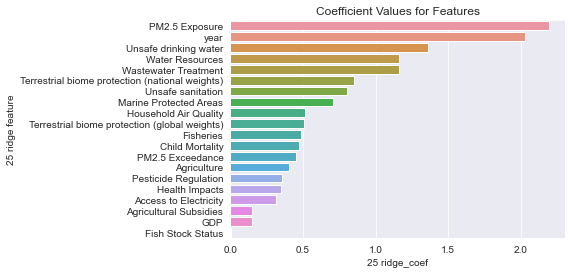

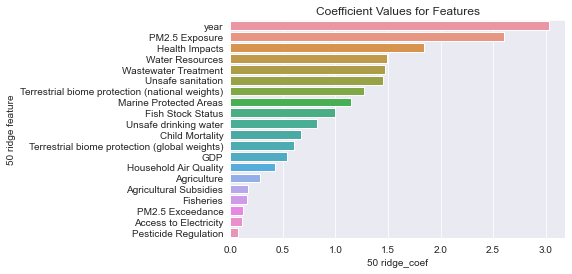

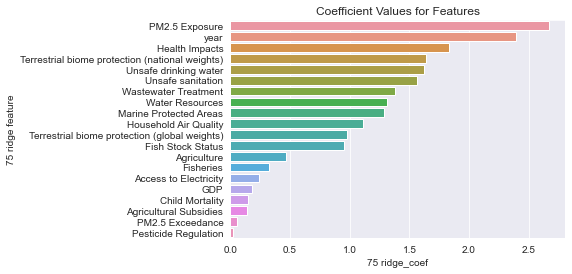

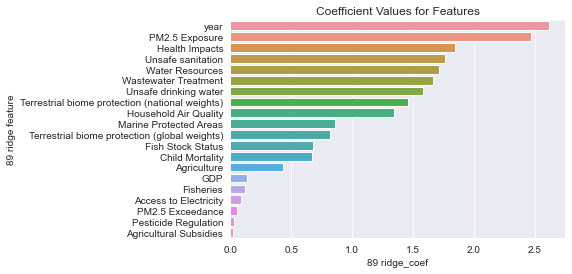

In [69]:
y_counter = 1
x_counter = 0
while y_counter <=24:
    sns.barplot(data=top_countries_df,
    y = bot_countries_df.iloc[:,y_counter],
    x = bot_countries_df.iloc[:,x_counter])
    plt.title('Coefficient Values for Features')
    plt.show()
    x_counter = x_counter + 2
    y_counter = y_counter + 2


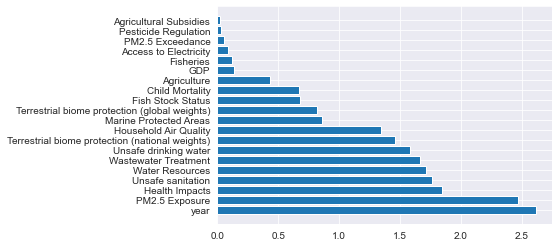

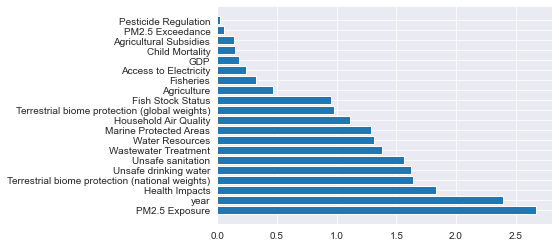

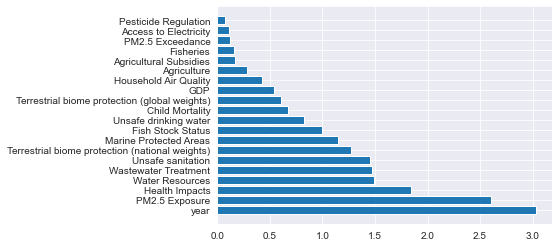

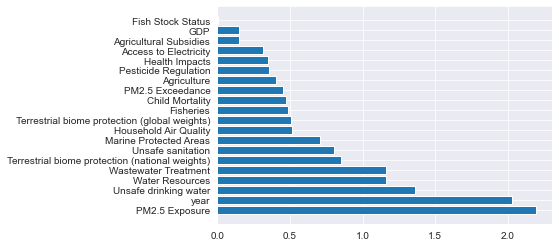

In [70]:

plt.barh( bot_countries_df['89 ridge feature'], bot_countries_df['89 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['75 ridge feature'], bot_countries_df['75 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['50 ridge feature'], bot_countries_df['50 ridge_coef'])
plt.show()
plt.barh(bot_countries_df['25 ridge feature'], bot_countries_df['25 ridge_coef'])
plt.show()

In [76]:
bot_countries_df

25 lr_coef                                       25 feature  \
0   1.603850e+00                                             year   
1   1.085718e-01                                   PM2.5 Exposure   
2   1.036476e-01                            Unsafe drinking water   
3   5.847499e-02                             Wastewater Treatment   
4   5.847499e-02                                  Water Resources   
5   5.010077e-02                                  Child Mortality   
6   4.886426e-02                                   Health Impacts   
7   4.528952e-02                           Agricultural Subsidies   
8   3.832266e-02  Terrestrial biome protection (national weights)   
9   3.562403e-02                            Household Air Quality   
10  2.590998e-02                           Marine Protected Areas   
11  1.857808e-02                                Unsafe sanitation   
12  1.438226e-02                            Access to Electricity   
13  1.168153e-02    Terrestrial biome protection (global weights)   
14  9.400741e-03                                      Agriculture   
15  5.908726e-03                             Pesticide Regulation   
16  4.391015e-03                                 PM2.5 Exceedance   
17  2.356265e-03                                Fish Stock Status   
18  4.435216e-04                                        Fisheries   
19  2.609302e-13                                              GDP   

      50 lr_coef                                       50 feature  \
0   2.310317e+00                                             year   
1   1.240563e-01                                   Health Impacts   
2   9.379255e-02                                  Water Resources   
3   8.845225e-02                                   PM2.5 Exposure   
4   8.190674e-02                                Unsafe sanitation   
5   5.340848e-02                                  Child Mortality   
6   4.542126e-02                             Wastewater Treatment   
7   4.404102e-02  Terrestrial biome protection (national weights)   
8   4.339576e-02                                Fish Stock Status   
9   3.829970e-02                            Unsafe drinking water   
10  3.453043e-02                           Marine Protected Areas   
11  2.286067e-02                                      Agriculture   
12  1.456452e-02    Terrestrial biome protection (global weights)   
13  1.398043e-02                            Household Air Quality   
14  1.228865e-02                                        Fisheries   
15  8.297020e-03                            Access to Electricity   
16  5.373427e-03                           Agricultural Subsidies   
17  4.651215e-03                             Pesticide Regulation   
18  2.808808e-03                                 PM2.5 Exceedance   
19  3.898826e-13                                              GDP   

      75 lr_coef                                       75 feature  \
0   1.495860e+00                                             year   
1   1.168222e-01                                   Health Impacts   
2   1.155963e-01                             Wastewater Treatment   
3   1.062724e-01                                   PM2.5 Exposure   
4   9.061660e-02                                Unsafe sanitation   
5   7.114872e-02                            Unsafe drinking water   
6   6.359189e-02  Terrestrial biome protection (national weights)   
7   4.618675e-02                                Fish Stock Status   
8   4.005629e-02                            Household Air Quality   
9   3.959359e-02                           Marine Protected Areas   
10  2.892769e-02                                  Child Mortality   
11  2.542494e-02                            Access to Electricity   
12  2.504414e-02                                        Fisheries   
13  1.987678e-02    Terrestrial biome protection (global weights)   
14  1.856099e-02                                 PM2.5 Exceedance   
15

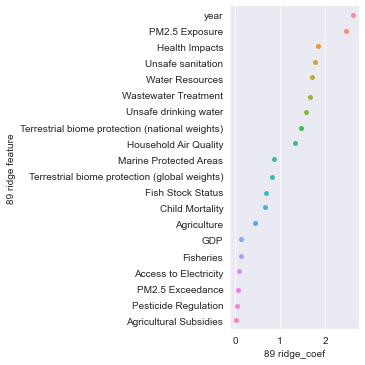

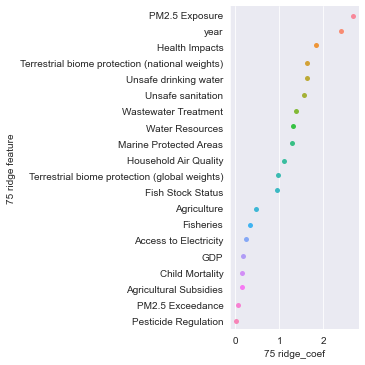

In [94]:
sns.catplot(data=bot_countries_df,
           orient='h', x='89 ridge_coef', y='89 ridge feature' )
sns.catplot(data=bot_countries_df,
           orient='h', x='75 ridge_coef', y='75 ridge feature')

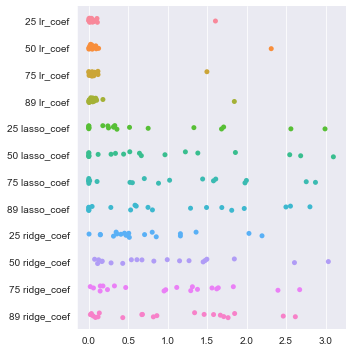

In [92]:
sns.catplot(data=bot_countries_df, orient='h')

In [116]:
bot_countries_df['25 feature'].sort_values()

12                              Access to Electricity
7                              Agricultural Subsidies
14                                        Agriculture
5                                     Child Mortality
17                                  Fish Stock Status
18                                          Fisheries
19                                                GDP
6                                      Health Impacts
9                               Household Air Quality
10                             Marine Protected Areas
16                                   PM2.5 Exceedance
1                                      PM2.5 Exposure
15                               Pesticide Regulation
13      Terrestrial biome protection (global weights)
8     Terrestrial biome protection (national weights)
2                               Unsafe drinking water
11                                  Unsafe sanitation
3                                Wastewater Treatment
4                           

In [181]:
catplot_df_25lr = pd.DataFrame(bot_countries_df[['25 feature','25 lr_coef']].copy())
catplot_df_25lr.rename(columns={'25 lr_coef':'coef', '25 feature': 'feature'}, inplace=True)
catplot_df_25lr['label'] = '25 lr_coef'
catplot_df_25lr

feature          coef       label
0                                              year  1.603850e+00  25 lr_coef
1                                    PM2.5 Exposure  1.085718e-01  25 lr_coef
2                             Unsafe drinking water  1.036476e-01  25 lr_coef
3                              Wastewater Treatment  5.847499e-02  25 lr_coef
4                                   Water Resources  5.847499e-02  25 lr_coef
5                                   Child Mortality  5.010077e-02  25 lr_coef
6                                    Health Impacts  4.886426e-02  25 lr_coef
7                            Agricultural Subsidies  4.528952e-02  25 lr_coef
8   Terrestrial biome protection (national weights)  3.832266e-02  25 lr_coef
9                             Household Air Quality  3.562403e-02  25 lr_coef
10                           Marine Protected Areas  2.590998e-02  25 lr_coef
11                                Unsafe sanitation  1.857808e-02  25 lr_coef
12                            Access to Electricity  1.438226e-02  25 lr_coef
13    Terrestrial biome protection (global weights)  1.168153e-02  25 lr_coef
14                                      Agriculture  9.400741e-03  25 lr_coef
15                             Pesticide Regulation  5.908726e-03  25 lr_coef
16                                 PM2.5 Exceedance  4.391015e-03  25 lr_coef
17                                Fish Stock Status  2.356265e-03  25 lr_coef
18                                        Fisheries  4.435216e-04  25 lr_coef
19                                              GDP  2.609302e-13  25 lr_coef

In [182]:
catplot_df_50lr = pd.DataFrame(bot_countries_df[['50 feature','50 lr_coef']].copy())
catplot_df_50lr['label'] = '50 lr_coef'
catplot_df_50lr.rename(columns={'50 lr_coef':'coef', '50 feature': 'feature'}, inplace=True)
catplot_df_50lr

feature          coef       label
0                                              year  2.310317e+00  50 lr_coef
1                                    Health Impacts  1.240563e-01  50 lr_coef
2                                   Water Resources  9.379255e-02  50 lr_coef
3                                    PM2.5 Exposure  8.845225e-02  50 lr_coef
4                                 Unsafe sanitation  8.190674e-02  50 lr_coef
5                                   Child Mortality  5.340848e-02  50 lr_coef
6                              Wastewater Treatment  4.542126e-02  50 lr_coef
7   Terrestrial biome protection (national weights)  4.404102e-02  50 lr_coef
8                                 Fish Stock Status  4.339576e-02  50 lr_coef
9                             Unsafe drinking water  3.829970e-02  50 lr_coef
10                           Marine Protected Areas  3.453043e-02  50 lr_coef
11                                      Agriculture  2.286067e-02  50 lr_coef
12    Terrestrial biome protection (global weights)  1.456452e-02  50 lr_coef
13                            Household Air Quality  1.398043e-02  50 lr_coef
14                                        Fisheries  1.228865e-02  50 lr_coef
15                            Access to Electricity  8.297020e-03  50 lr_coef
16                           Agricultural Subsidies  5.373427e-03  50 lr_coef
17                             Pesticide Regulation  4.651215e-03  50 lr_coef
18                                 PM2.5 Exceedance  2.808808e-03  50 lr_coef
19                                              GDP  3.898826e-13  50 lr_coef

In [185]:
catplot_df_75lr = pd.DataFrame(bot_countries_df[['75 feature','75 lr_coef']].copy())
catplot_df_75lr['label'] = '75 lr_coef'
catplot_df_75lr.rename(columns={'75 lr_coef':'coef', '75 feature': 'feature'}, inplace=True)
catplot_df_75lr

feature          coef       label
0                                              year  1.495860e+00  75 lr_coef
1                                    Health Impacts  1.168222e-01  75 lr_coef
2                              Wastewater Treatment  1.155963e-01  75 lr_coef
3                                    PM2.5 Exposure  1.062724e-01  75 lr_coef
4                                 Unsafe sanitation  9.061660e-02  75 lr_coef
5                             Unsafe drinking water  7.114872e-02  75 lr_coef
6   Terrestrial biome protection (national weights)  6.359189e-02  75 lr_coef
7                                 Fish Stock Status  4.618675e-02  75 lr_coef
8                             Household Air Quality  4.005629e-02  75 lr_coef
9                            Marine Protected Areas  3.959359e-02  75 lr_coef
10                                  Child Mortality  2.892769e-02  75 lr_coef
11                            Access to Electricity  2.542494e-02  75 lr_coef
12                                        Fisheries  2.504414e-02  75 lr_coef
13    Terrestrial biome protection (global weights)  1.987678e-02  75 lr_coef
14                                 PM2.5 Exceedance  1.856099e-02  75 lr_coef
15                                      Agriculture  9.248054e-03  75 lr_coef
16                           Agricultural Subsidies  6.441707e-03  75 lr_coef
17                                  Water Resources  3.464133e-03  75 lr_coef
18                             Pesticide Regulation  8.312358e-04  75 lr_coef
19                                              GDP  1.075945e-13  75 lr_coef

In [186]:
catplot_df_89lr = pd.DataFrame(bot_countries_df[['89 feature','89 lr_coef']].copy())
catplot_df_89lr['label'] = '89 lr_coef'
catplot_df_89lr.rename(columns={'89 lr_coef':'coef', '89 feature': 'feature'}, inplace=True)
catplot_df_89lr

feature          coef       label
0                                              year  1.843100e+00  89 lr_coef
1                                   Water Resources  1.787608e-01  89 lr_coef
2                                    Health Impacts  9.905219e-02  89 lr_coef
3                                 Unsafe sanitation  8.952542e-02  89 lr_coef
4                                    PM2.5 Exposure  8.759500e-02  89 lr_coef
5                             Unsafe drinking water  6.639470e-02  89 lr_coef
6   Terrestrial biome protection (national weights)  5.262187e-02  89 lr_coef
7                              Wastewater Treatment  5.220894e-02  89 lr_coef
8                                   Child Mortality  4.911841e-02  89 lr_coef
9                             Household Air Quality  4.360074e-02  89 lr_coef
10                                Fish Stock Status  2.788333e-02  89 lr_coef
11                           Marine Protected Areas  2.513648e-02  89 lr_coef
12    Terrestrial biome protection (global weights)  2.052415e-02  89 lr_coef
13                                      Agriculture  9.463793e-03  89 lr_coef
14                                        Fisheries  8.049547e-03  89 lr_coef
15                            Access to Electricity  5.599944e-03  89 lr_coef
16                             Pesticide Regulation  3.431989e-03  89 lr_coef
17                                 PM2.5 Exceedance  3.316653e-03  89 lr_coef
18                           Agricultural Subsidies  2.349750e-03  89 lr_coef
19                                              GDP  6.383782e-14  89 lr_coef

In [187]:
lr_catplot = pd.concat([catplot_df_25lr,catplot_df_50lr,catplot_df_75lr,catplot_df_89lr],axis=0, ignore_index=True)

In [188]:
lr_catplot

feature          coef       label
0                     year  1.603850e+00  25 lr_coef
1           PM2.5 Exposure  1.085718e-01  25 lr_coef
2    Unsafe drinking water  1.036476e-01  25 lr_coef
3     Wastewater Treatment  5.847499e-02  25 lr_coef
4          Water Resources  5.847499e-02  25 lr_coef
..                     ...           ...         ...
75   Access to Electricity  5.599944e-03  89 lr_coef
76    Pesticide Regulation  3.431989e-03  89 lr_coef
77        PM2.5 Exceedance  3.316653e-03  89 lr_coef
78  Agricultural Subsidies  2.349750e-03  89 lr_coef
79                     GDP  6.383782e-14  89 lr_coef

[80 rows x 3 columns]

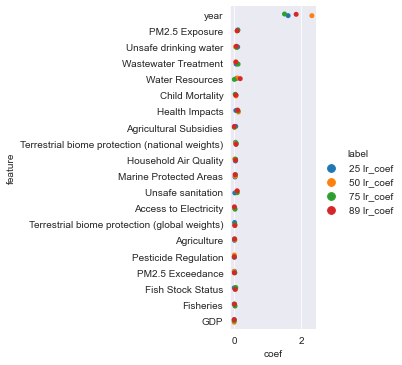

In [192]:
sns.catplot(data=lr_catplot, x='coef', y='feature', hue='label', orient='h')

In [133]:
coef_columns = [x for x in bot_countries_df.columns if 'coef' in x]
    

In [120]:
for col in coef_columns:
    catplot_df[col] = bot_countries_df[col].copy()

In [134]:
catplot_df['model_type'] = coef_columns

ValueError: Length of values (12) does not match length of index (20)

extra practice / delete later

In [71]:
stop error

SyntaxError: invalid syntax (<ipython-input-71-b6379532b430>, line 1)

In [ ]:
X = top_10_df.drop(columns=drop_list)
y = top_10_df['Environmental Performance Index']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train,y_train)

In [ ]:
lr.score(X_train,y_train), lr.score(X_test,y_test)

In [ ]:
print(list(zip(lr.coef_, X.columns)))

In [ ]:
coefs = pd.DataFrame(zip(lr.coef_, X.columns), columns=['coef', 'feature'])

In [ ]:
coefs = pd.DataFrame(zip(lr.coef_, X.columns), columns=['coef', 'feature'])
coefs.sort_values('coef',ascending=False, inplace=True)
coefs.reset_index(inplace=True)
coefs

In [ ]:
 sc = StandardScaler()
    
Xs_train = sc.fit_transform(X_train)
Xs_test = sc.transform(X_test)

#LASSO    
lasso = Lasso(random_state = 42, selection = 'random')

lasso_pipe_params = {
    'alpha': loguniform(.001, 100),
    'tol': loguniform(.00001, .001),
    'max_iter': uniform(100, 10000)
}

lasso_rs = RandomizedSearchCV(lasso, param_distributions = lasso_pipe_params, 
                         cv = 5,n_iter=1000,verbose=1, n_jobs = -2, random_state = 42)

lasso_rs.fit(Xs_train, y_train)

In [ ]:
lasso_rs.score(Xs_train,y_train), lasso_rs.score(Xs_test,y_test)

In [ ]:
lasso_rs.best_params_

In [ ]:
ridge = Ridge(random_state = 42)

ridge_pipe_params = {
    'alpha': loguniform(.001, 100),
    'tol': loguniform(.00001, .001),
    'max_iter': uniform(100, 10000)
}

ridge_rs = RandomizedSearchCV(ridge, param_distributions = ridge_pipe_params, cv = 5, n_jobs = -2,n_iter=1000,verbose=1, random_state = 42)
ridge_rs.fit(Xs_train, y_train)

In [ ]:
ridge_rs.score(Xs_train,y_train), ridge_rs.score(Xs_test,y_test)

In [ ]:
ridge_rs.best_estimator_.coef_

In [ ]:
ridge_rs.best_params_

pre2015

In [ ]:
top_10_df_pre15 = top_10_df[top_10_df['year'] <= 2015]
top_10_df_post15 = top_10_df[top_10_df['year'] > 2015]

In [ ]:
top_10_df_pre15

In [ ]:
top_10_df_post15

In [ ]:
X = top_10_df_post15.drop(columns=drop_list)
y = top_10_df_post15['Environmental Performance Index']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=.5)

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train,y_train)

In [ ]:
lr.score(X_train,y_train), lr.score(X_test,y_test)